#Team Assignment 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Team Information
Team Name: Nu  
Team Member: Ellen Wang, Niazi Murataj, Helen Charbonnet, Peter Shelley, Abhi Gadudasu, James Park

##Overview

### Key Assumptions
- We assume we are at April, 2019

### Explanation for the data structure
- df_full: temporary place holder for the full dataset model
- df_raw: raw data of dataset
- df: will refer both to the 1000 sample data or the full data model depending on the needs for computation (after cleaning, after scaling)
  - x_s: numerical number, the location of x variables start
  - d_s: numerical number, the location of dummy variables start
- red_flag: column inside df, it is referring to the loans with significant problem. The purpose of this red_flag variable is to reduce the dimension of the dataset but still maintain its statistical power (within df)
  - detailed defition in the cell
- df_hist: the historical loan data (data except current status loans, subset of df) For all Analysis, training and testing (sclaed and cleaned)
- df_curr: current status loans (subset of df, scaled and cleaned)
- X_train, X_test, Y_train, Y_test: temporary holder for the model

![picture](https://drive.google.com/uc?export=view&id=1T_baZgVzs6vkM6GzVgsYS9ENh55wQkCD)

## PART I: Data Cleaning and Data Wrangling

###Install packages and load data

In [ ]:
!pip install pickle5
import pickle5 as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import re #imports regular expression module
from google.colab import files

import seaborn as sns
import sklearn

from sklearn import metrics, model_selection, preprocessing, linear_model
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.datasets import make_classification, make_regression
import sympy

from datetime import timedelta
import random

In [ ]:
# DON'T TOUCH THESE!!!
drive.mount('/content/drive', force_remount=True)
# df = pd.read_csv('./accepted_2007_to_2018Q4.csv')
# df = pd.read_csv('./accepted_1000_sample.csv')
# df = pd.read_csv('/content/drive/MyDrive/COMP488_Group_Project_2/DATA/accepted_1000_sample.csv')
df = pd.read_csv('/content/drive/MyDrive/COMP488_Group_Project_2/DATA/accepted_100K_sample.csv')
# df = pd.read_csv('/content/drive/MyDrive/COMP488_Group_Project_2/DATA/accepted_2007_to_2018Q4.csv')
df_raw = df.copy()

Mounted at /content/drive


In [ ]:
df['int_rate'].max()

30.99

In [ ]:
# DON'T TOUCH THESE!!!
#This cell is used for randomly sampling a smaller dataset for analysis
#df = df.sample(n=100000)
#df.to_csv('accepted_100K_sample.csv')
#files.download('accepted_100K_sample.csv')

### 1. Data Cleaning

Upon initial data inspection, we have a total of 2,260,668 data points with 878,317 available loans for investing, which is 38.8%.

The date of this data ranging from April 2008 to September 2018



####1.1 Drop Special Applicants

In [ ]:
# Joint App Drop
df = df[df.application_type != "Joint App"]
df.drop(columns=['application_type','annual_inc_joint','dti_joint','verification_status_joint'], inplace=True)

# The end of the sheet is all exta information for joint loan
end_col = df.columns.get_loc("total_il_high_credit_limit")
df = df.iloc[:,0:end_col+1]

In [ ]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1989940,85242003,NaN,17600.0,17600.0,17600.0,36 months,25.69,706.22,F,F1,Owner/Driver,3 years,MORTGAGE,40000.0,Verified,Aug-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,443xx,OH,30.12,0.0,Aug-2010,675.0,679.0,2.0,NaN,23.0,7.0,1.0,11494.0,43.2,9.0,f,3314.77,...,2.0,0.0,4.0,4.0,3837.0,4435.0,64.5,0.0,0.0,71.0,37.0,4.0,4.0,0.0,4.0,NaN,2.0,NaN,0.0,2.0,4.0,3.0,4.0,3.0,5.0,6.0,4.0,7.0,0.0,0.0,0.0,3.0,100.0,33.3,0.0,1.0,65919.0,26862.0,12500.0,39319.0
1,1495797,135432107,NaN,7000.0,7000.0,7000.0,36 months,6.19,213.56,A,A2,Claims Team Manager,10+ years,MORTGAGE,100139.0,Not Verified,Jun-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,650xx,MO,10.86,0.0,Nov-2003,830.0,834.0,2.0,NaN,NaN,10.0,0.0,25670.0,45.6,16.0,w,5369.58,...,2.0,0.0,4.0,1.0,23079.0,30238.0,3.4,0.0,0.0,68.0,175.0,25.0,5.0,2.0,25.0,NaN,0.0,NaN,0.0,1.0,2.0,6.0,9.0,4.0,7.0,10.0,2.0,10.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,288004.0,68476.0,31300.0,50204.0
2,1755465,9848215,NaN,23850.0,23850.0,23850.0,36 months,14.98,826.54,C,C3,Clerical,10+ years,MORTGAGE,54000.0,Verified,Dec-2013,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/17/13 > I will use this...,debt_consolidation,Debt Free,785xx,TX,15.17,1.0,Sep-1999,665.0,669.0,0.0,8.0,NaN,9.0,0.0,15105.0,75.1,29.0,f,0.00,...,NaN,NaN,NaN,1.0,22720.0,3910.0,78.9,0.0,0.0,136.0,171.0,31.0,9.0,2.0,88.0,8.0,9.0,8.0,0.0,4.0,5.0,4.0,11.0,6.0,7.0,21.0,5.0,9.0,0.0,0.0,0.0,1.0,89.7,25.0,0.0,0.0,201332.0,38002.0,18500.0,21032.0
3,852453,136521416,NaN,34625.0,34625.0,34575.0,36 months,15.02,1200.63,C,C3,Sr. Admin/Office Manager,10+ years,MORTGAGE,76960.0,Verified,Jul-2018,In Grace Period,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,708xx,LA,36.94,1.0,Feb-2006,710.0,714.0,0.0,12.0,NaN,21.0,0.0,8483.0,19.6,38.0,f,29051.11,...,6.0,2.0,1.0,9.0,11851.0,21833.0,21.5,0.0,0.0,142.0,149.0,2.0,2.0,2.0,2.0,86.0,7.0,12.0,2.0,6.0,11.0,9.0,12.0,10.0,17.0,26.0,11.0,21.0,0.0,0.0,0.0,3.0,78.9,0.0,0.0,0.0,317726.0,90265.0,27800.0,113560.0
4,2205274,93461239,NaN,9500.0,9500.0,9500.0,36 months,14.99,329.28,C,C4,Driver,3 years,MORTGAGE,55000.0,Source Verified,Nov-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,477xx,IN,12.70,0.0,Jun-2005,675.0,679.0,1.0,NaN,86.0,8.0,1.0,1042.0,11.6,13.0,f,0.00,...,8.0,4.0,13.0,6.0,13281.0,2761.0,21.1,0.0,0.0,137.0,106.0,3.0,2.0,1.0,27.0,NaN,3.0,NaN,1.0,1.0,3.0,2.0,5.0,5.0,4.0,7.0,3.0,8.0,0.0,0.0,0.0,4.0,92.3,0.0,1.0,0.0,114860.0,28481.0,3500.0,27408.0


####1.2 Drop Unnecessary Information

In [ ]:
# drop loan_amnt and funded_amnt and use funded_amnt_inv => that's the money the investor is lending
columns_to_drop = ['member_id', 'url','zip_code','desc','verification_status','addr_state',
                    'policy_code','pymnt_plan','next_pymnt_d','tax_liens', 'emp_title']
df.drop(columns=columns_to_drop, inplace=True)
df=df.iloc[:,1:]

####1.3 Reduce multicollinearity

The total payment to investor is very similar and barely away from the total payment up to date. Therefore, we can reasonably remove total payment from investor to avoid collinearity.

In [ ]:
df[["loan_status","total_pymnt","total_pymnt_inv"]][(df["total_pymnt"]-df["total_pymnt_inv"])>100]
df.drop("total_pymnt_inv",axis=1, inplace=True)

We concluded that funded amount and funded amount by investors are very similar

In [ ]:
df[["loan_status","funded_amnt","funded_amnt_inv"]][(df["funded_amnt"]-df["funded_amnt_inv"])>100]
df.drop(["funded_amnt_inv","funded_amnt"],axis=1, inplace=True)

####1.4 Convert Categorical Data

In [ ]:
#check for nan
df=df[~df["sub_grade"].isna()]

In [ ]:
# display all categorical data
for col in df.select_dtypes(include=[object]).columns:
  if(col not in ['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']):
    df[col]=df[col].astype('category')
display(df.select_dtypes(include='category'))

,term,grade,sub_grade,emp_length,home_ownership,loan_status,purpose,title,initial_list_status
0,36 months,F,F1,3 years,MORTGAGE,Current,debt_consolidation,Debt consolidation,f
1,36 months,A,A2,10+ years,MORTGAGE,Current,debt_consolidation,Debt consolidation,w
2,36 months,C,C3,10+ years,MORTGAGE,Fully Paid,debt_consolidation,Debt Free,f
3,36 months,C,C3,10+ years,MORTGAGE,In Grace Period,debt_consolidation,Debt consolidation,f
4,36 months,C,C4,3 years,MORTGAGE,Charged Off,debt_consolidation,Debt consolidation,f
...,...,...,...,...,...,...,...,...,...
99995,36 months,A,A1,< 1 year,RENT,Fully Paid,debt_consolidation,Debt consolidation,w
99996,36 months,E,E2,6 years,RENT,Charged Off,debt_consolidation,Debt consolidation,f
99997,36 months,B,B4,10+ years,OWN,Fully Paid,debt_consolidation,Debt consolidation,w
99998,36 months,A,A5,7 years,MORTGAGE,Current,credit_card,Credit card refinancing,f


In [ ]:
# convert different type into dummy variables
df["pur_car"] = 0
df.loc[df.purpose=="car","pur_car"]=1
df["pur_creditCard"] = 0
df.loc[df.purpose=="credit_card","pur_creditCard"]=1
df["pur_debt"] = 0
df.loc[df.purpose=="debt_consolidation","pur_debt"]=1

In [ ]:
df.drop(columns=['purpose', 'title'], inplace=True)

Map all categorical columns to numerical values

In [ ]:
# ## This replaces 'loan_status' and 'term' values with values in map
map = {'n': False, 'y': True}
#df['pymnt_plan'].replace(map, inplace=True)
df['term'].replace({'36 months':36, ' 36 months':36, '60 months':60, ' 60 months': 60}, inplace=True)
df['term'].astype(int)

0        36
1        36
2        36
3        36
4        36
         ..
99995    36
99996    36
99997    36
99998    36
99999    60
Name: term, Length: 94592, dtype: int64

####1.5 Create a red-flag indicator

In [ ]:
df["red_flag"] = 0
df.loc[(df.delinq_2yrs>=3.099687e-01)|
        (df.inq_last_6mths>=5.872043e-01)|
        (df.pub_rec>=1.999080e-01)|
        (df.collections_12_mths_ex_med>=1.852078e-02)|
        (df.mths_since_last_major_derog>=44.072501)|
        (df.chargeoff_within_12_mths>=8.655897e-03)|
       (df.delinq_amnt>=1.280829e+01)
         ,"red_flag"]=1
sum_red_flag = ['delinq_2yrs','inq_last_6mths','pub_rec',
                'collections_12_mths_ex_med','mths_since_last_major_derog',
                'acc_now_delinq',"chargeoff_within_12_mths","delinq_amnt"]
df.drop(columns=sum_red_flag, inplace=True)

####1.5 Create Credit Urgency Indicator

In [ ]:
df['Credit_Urgency_75%'] = 0
df.loc[(df.all_util>=71)|
        (df.avg_cur_bal>=17919.5)|
        (df.bc_util>=79.6)|
        (df.il_util>=86)|
        (df.max_bal_bc>=7208.75)|
        (df.mo_sin_old_il_acct>=155)|
       (df.mo_sin_old_rev_tl_op>=229)|
       (df.mo_sin_rcnt_rev_tl_op>=17)|
       (df.mo_sin_rcnt_tl>=10)|
       (df.mort_acc>=3)|
       (df.mths_since_rcnt_il>=22)|
       (df.mths_since_recent_bc>=29)|
       (df.num_actv_bc_tl>=5)|
       (df.num_bc_sats>=6)|
       (df.num_bc_tl>=11)|
       (df.num_il_tl>=11)|
       (df.num_op_rev_tl>=10)|
       (df.num_rev_accts>=19)|
       (df.num_rev_tl_bal_gt_0>=7)|
       (df.num_sats>=14)|
       (df.num_tl_30dpd>=1)|
       (df.num_tl_90g_dpd_24m>=4)|
       (df.num_tl_op_past_12m>=3)|
       (df.open_acc>=14)|
       (df.open_il_12m>=1)|
       (df.open_il_24m>=2)|
       (df.open_act_il>=3)|
       (df.out_prncp>=3958.9)|
       (df.out_prncp_inv>=3953.68)|
       (df.percent_bc_gt_75>=66.7)|
       (df.revol_bal>=19156.5)|
       (df.tot_cur_bal>=202514)|
       (df.total_bal_ex_mort>=64196.5)|
       (df.total_bal_il>=46475)
       ,"Credit_Urgency_75%"]=1

In [ ]:
# everything except Out_prncp, total_cur_bal
sum_credit_urgent = ['all_util','avg_cur_bal','bc_util',"il_util","max_bal_bc","mo_sin_old_il_acct",
                     "mo_sin_old_rev_tl_op",'mo_sin_rcnt_rev_tl_op',"mo_sin_rcnt_tl","mort_acc",
                     "mths_since_rcnt_il","mths_since_recent_bc","num_actv_bc_tl","num_bc_sats",
                     "num_bc_tl","num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0",
                     "num_sats","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m",
                     "open_acc","open_il_12m","open_il_24m","open_act_il","out_prncp_inv","percent_bc_gt_75",
                     "revol_bal","total_bal_ex_mort","total_bal_il"]
df.drop(columns=sum_credit_urgent, inplace=True)

####1.6 Replace some nan with reasonable substituts

In [ ]:
df['open_acc_6m'] = df['open_acc_6m'].fillna(0)
df['open_rv_12m'] = df['open_rv_12m'].fillna(0)
df['open_rv_24m'] = df['open_rv_24m'].fillna(0)
df['acc_open_past_24mths'] = df['acc_open_past_24mths'].fillna(0)
df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(0)
df['inq_fi'] = df['inq_fi'].fillna(0)
df['total_cu_tl'] = df['total_cu_tl'].fillna(0)
df['inq_last_12m'] = df['inq_last_12m'].fillna(0)
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(0)
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].fillna(0)
df['mths_since_recent_inq'] = df['mths_since_recent_inq'].fillna(0)
df['num_accts_ever_120_pd'] = df['num_accts_ever_120_pd'].fillna(0)
df['num_actv_rev_tl'] = df['num_actv_rev_tl'].fillna(0)
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0)
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].fillna(0)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)
df['tot_hi_cred_lim'] = df['tot_hi_cred_lim'].fillna(0)
df['total_bc_limit'] = df['total_bc_limit'].fillna(0)
df['total_il_high_credit_limit'] = df['total_il_high_credit_limit'].fillna(0)

###2. Data Wrangling

#### 2.1 Formulate return

In [ ]:
df["time_till_last_paid"]=pd.to_datetime(df.last_pymnt_d, format='%b-%Y')-pd.to_datetime(df.issue_d, format='%b-%Y')
df["actual_repayment_time"] = df["time_till_last_paid"]/np.timedelta64(1,"D")

In [ ]:
df.drop(columns="time_till_last_paid", inplace=True)
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('actual_repayment_time')))
df = df.reindex(columns= cols)

In [ ]:
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('last_pymnt_d')))
cols.insert(0, cols.pop(cols.index('issue_d')))
cols.insert(0, cols.pop(cols.index('loan_status')))
cols.insert(0, cols.pop(cols.index('sub_grade')))
cols.insert(0, cols.pop(cols.index('grade')))
df = df.reindex(columns= cols)

In [ ]:
df.drop(columns="last_credit_pull_d", inplace=True)

In [ ]:
df.drop(columns="earliest_cr_line", inplace=True)

In [ ]:
df.loc[df.loan_status != "Current","yr_ret"] = ((df.total_pymnt/df.loan_amnt)**(365/(df["actual_repayment_time"]))-1)*100
df.loc[df.loan_status == "Current","yr_ret"] = 0 # Put this zero for the current loans (which does not have a return now...)

In [ ]:
# There are some loan that are paid the same day it is issued, we will ignore them
df[df['yr_ret']>=100][["yr_ret","total_pymnt","loan_amnt","actual_repayment_time","loan_status","last_pymnt_d","issue_d"]]
df = df[df.actual_repayment_time!=0]

In [ ]:
return_columns = ['total_pymnt','total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','tot_coll_amt']
df.drop(columns=return_columns, inplace=True)

In [ ]:
# Move Y till the front
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('yr_ret')))
df = df.reindex(columns= cols)

####2.2 Convert remaining categorical data

In [ ]:
# convert ownership into dummy
df["home_rent"] = 0
df.loc[df.home_ownership=="RENT","home_rent"]=1
df["home_mortgage"] = 0
df.loc[df.home_ownership=="MORTGAGE","home_mortgage"]=1

In [ ]:
df.drop(columns="home_ownership", inplace=True)

In [ ]:
# convert emp_length into dummy by seperating whether it is over 10 years
df["emp_length_over_10"] = 0
df.loc[df.emp_length.str.contains('10+',na=False),"emp_length_over_10"] = 1

In [ ]:
df.drop(columns="emp_length", inplace=True)

In [ ]:
# convert inital list into dummy
df["initial_list_status_w"] = 0
df.loc[df.initial_list_status=="w","initial_list_status_w"]=1
df["initial_list_status_f"] = 0
df.loc[df.initial_list_status=="f","initial_list_status_f"]=1

In [ ]:
df.drop(columns="initial_list_status", inplace=True)

In [ ]:
df.head()

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,mths_since_last_delinq,mths_since_last_record,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0.000000,F,F1,Current,Aug-2016,Mar-2019,942.0,85242003,17600.0,36,25.69,706.22,40000.0,30.12,675.0,679.0,NaN,23.0,43.2,9.0,3314.77,689.0,685.0,26862.0,2.0,3.0,4.0,26600.0,2.0,0.0,4.0,4.0,4435.0,NaN,2.0,NaN,0.0,4.0,0.0,100.0,0.0,65919.0,12500.0,39319.0,0,0,1,1,1,0,1,0,0,1
1,0.000000,A,A2,Current,Jun-2018,Mar-2019,273.0,135432107,7000.0,36,6.19,213.56,100139.0,10.86,830.0,834.0,NaN,NaN,45.6,16.0,5369.58,789.0,785.0,230785.0,1.0,0.0,0.0,56300.0,2.0,0.0,4.0,1.0,30238.0,NaN,0.0,NaN,0.0,2.0,0.0,100.0,0.0,288004.0,31300.0,50204.0,0,0,1,1,1,0,1,1,1,0
2,10.527226,C,C3,Fully Paid,Dec-2013,Nov-2015,700.0,9848215,23850.0,36,14.98,826.54,54000.0,15.17,665.0,669.0,8.0,NaN,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,8.0,9.0,8.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0,21032.0,0,0,1,1,1,0,1,1,0,1
3,-91.013495,C,C3,In Grace Period,Jul-2018,Feb-2019,215.0,136521416,34625.0,36,15.02,1200.63,76960.0,36.94,710.0,714.0,12.0,NaN,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,86.0,7.0,12.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0,113560.0,0,0,1,1,1,0,1,1,0,1
4,-99.997599,C,C4,Charged Off,Nov-2016,Feb-2017,92.0,93461239,9500.0,36,14.99,329.28,55000.0,12.70,675.0,679.0,NaN,86.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,NaN,3.0,NaN,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0,27408.0,0,0,1,1,1,0,1,0,0,1


####2.3 Create dummy seperators - grade, paid, test train

In [ ]:
# create dummy grade seperators
df["g_A"] = 0
df.loc[df.grade=="A","g_A"]=1
df["g_B"] = 0
df.loc[df.grade=="B","g_B"]=1
df["g_C"] = 0
df.loc[df.grade=="C","g_C"]=1
df["g_D"] = 0
df.loc[df.grade=="D","g_D"]=1
df["g_F"] = 0
df.loc[df.grade=="F","g_F"]=1

In [ ]:
# create dummy variable for sub category
df["l_1"] = 0
df.loc[df.sub_grade.str.contains("1"),"l_1"]=1
df["l_2"] = 0
df.loc[df.sub_grade.str.contains("2"),"l_2"]=1
df["l_3"] = 0
df.loc[df.sub_grade.str.contains("3"),"l_3"]=1
df["l_4"] = 0
df.loc[df.sub_grade.str.contains("4"),"l_4"]=1
df["l_5"] = 0
df.loc[df.sub_grade.str.contains("5"),"l_5"]=1

In [ ]:
# create paid seperators
df["Paid"] = 0
df.loc[df.loan_status=="Fully Paid","Paid"]=1

In [ ]:
# create test and train dummy
df["test"] = 0
df["train"] = 0
df["Current"] = 0
df.loc[df.loan_status=="Current","Current"]=1

In [ ]:
# turn them to dummy
df["test"] = df["test"].astype(bool)
df["g_A"] = df["g_A"].astype(bool)
df["g_B"] = df["g_B"].astype(bool)
df["g_C"] = df["g_C"].astype(bool)
df["g_D"] = df["g_D"].astype(bool)
df["g_F"] = df["g_F"].astype(bool)

df["l_1"] = df["l_1"].astype(bool)
df["l_2"] = df["l_2"].astype(bool)
df["l_3"] = df["l_3"].astype(bool)
df["l_4"] = df["l_4"].astype(bool)
df["l_5"] = df["l_5"].astype(bool)

df["Paid"] = df["Paid"].astype(bool)
df["train"] = df["train"].astype(bool)
df["Current"] = df["Current"].astype(bool)

In [ ]:
# Reorganize everything
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('mths_since_last_delinq')))
cols.insert(0, cols.pop(cols.index('mths_since_last_record')))
cols.insert(0, cols.pop(cols.index('mths_since_recent_bc_dlq')))
cols.insert(0, cols.pop(cols.index('mths_since_recent_revol_delinq')))
cols.insert(0, cols.pop(cols.index('test')))
cols.insert(0, cols.pop(cols.index('train')))
cols.insert(0, cols.pop(cols.index('l_5')))
cols.insert(0, cols.pop(cols.index('l_4')))
cols.insert(0, cols.pop(cols.index('l_3')))
cols.insert(0, cols.pop(cols.index('l_2')))
cols.insert(0, cols.pop(cols.index('l_1')))
cols.insert(0, cols.pop(cols.index('g_F')))
cols.insert(0, cols.pop(cols.index('g_D')))
cols.insert(0, cols.pop(cols.index('g_C')))
cols.insert(0, cols.pop(cols.index('g_B')))
cols.insert(0, cols.pop(cols.index('g_A')))
cols.insert(0, cols.pop(cols.index('Paid')))
cols.insert(0, cols.pop(cols.index('Current')))
cols.insert(0, cols.pop(cols.index('last_pymnt_d')))
cols.insert(0, cols.pop(cols.index('issue_d')))
cols.insert(0, cols.pop(cols.index('loan_status')))
cols.insert(0, cols.pop(cols.index('sub_grade')))
cols.insert(0, cols.pop(cols.index('grade')))
cols.insert(0, cols.pop(cols.index('yr_ret')))
df = df.reindex(columns= cols)

In [ ]:
  # define the start location of scaled x variables start
  x_s = df.columns.get_loc("actual_repayment_time")
  # define the start location of all x variables start
  all_x_s = df.columns.get_loc("mths_since_recent_revol_delinq")
  # define the start location of dummy variables start
  d_s = df.columns.get_loc("pur_car")

In [ ]:
df.iloc[:,d_s:]

,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0,0,1,1,1,0,1,0,0,1
1,0,0,1,1,1,0,1,1,1,0
2,0,0,1,1,1,0,1,1,0,1
3,0,0,1,1,1,0,1,1,0,1
4,0,0,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,0,0,1,0,1,1,0,0,1,0
99996,0,0,1,1,1,1,0,0,0,1
99997,0,0,1,1,1,0,0,1,1,0
99998,0,1,0,0,1,0,1,0,0,1


In [ ]:
df.head()

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0.000000,F,F1,Current,Aug-2016,Mar-2019,True,False,False,False,False,False,True,True,False,False,False,False,False,False,NaN,NaN,23.0,NaN,942.0,85242003,17600.0,36,25.69,706.22,40000.0,30.12,675.0,679.0,43.2,9.0,3314.77,689.0,685.0,26862.0,2.0,3.0,4.0,26600.0,2.0,0.0,4.0,4.0,4435.0,2.0,0.0,4.0,0.0,100.0,0.0,65919.0,12500.0,39319.0,0,0,1,1,1,0,1,0,0,1
1,0.000000,A,A2,Current,Jun-2018,Mar-2019,True,False,True,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,273.0,135432107,7000.0,36,6.19,213.56,100139.0,10.86,830.0,834.0,45.6,16.0,5369.58,789.0,785.0,230785.0,1.0,0.0,0.0,56300.0,2.0,0.0,4.0,1.0,30238.0,0.0,0.0,2.0,0.0,100.0,0.0,288004.0,31300.0,50204.0,0,0,1,1,1,0,1,1,1,0
2,10.527226,C,C3,Fully Paid,Dec-2013,Nov-2015,False,True,False,False,True,False,False,False,False,True,False,False,False,False,8.0,8.0,NaN,8.0,700.0,9848215,23850.0,36,14.98,826.54,54000.0,15.17,665.0,669.0,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,9.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0,21032.0,0,0,1,1,1,0,1,1,0,1
3,-91.013495,C,C3,In Grace Period,Jul-2018,Feb-2019,False,False,False,False,True,False,False,False,False,True,False,False,False,False,12.0,86.0,NaN,12.0,215.0,136521416,34625.0,36,15.02,1200.63,76960.0,36.94,710.0,714.0,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,7.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0,113560.0,0,0,1,1,1,0,1,1,0,1
4,-99.997599,C,C4,Charged Off,Nov-2016,Feb-2017,False,False,False,False,True,False,False,False,False,False,True,False,False,False,NaN,NaN,86.0,NaN,92.0,93461239,9500.0,36,14.99,329.28,55000.0,12.70,675.0,679.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,3.0,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0,27408.0,0,0,1,1,1,0,1,0,0,1


In [ ]:
df.iloc[:,x_s:d_s-1]

,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit
0,942.0,85242003,17600.0,36,25.69,706.22,40000.0,30.12,675.0,679.0,43.2,9.0,3314.77,689.0,685.0,26862.0,2.0,3.0,4.0,26600.0,2.0,0.0,4.0,4.0,4435.0,2.0,0.0,4.0,0.0,100.0,0.0,65919.0,12500.0
1,273.0,135432107,7000.0,36,6.19,213.56,100139.0,10.86,830.0,834.0,45.6,16.0,5369.58,789.0,785.0,230785.0,1.0,0.0,0.0,56300.0,2.0,0.0,4.0,1.0,30238.0,0.0,0.0,2.0,0.0,100.0,0.0,288004.0,31300.0
2,700.0,9848215,23850.0,36,14.98,826.54,54000.0,15.17,665.0,669.0,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,9.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0
3,215.0,136521416,34625.0,36,15.02,1200.63,76960.0,36.94,710.0,714.0,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,7.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0
4,92.0,93461239,9500.0,36,14.99,329.28,55000.0,12.70,675.0,679.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,3.0,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1065.0,65642231,8000.0,36,5.32,240.92,130000.0,2.41,695.0,699.0,11.6,18.0,0.00,809.0,805.0,8700.0,0.0,0.0,0.0,25900.0,0.0,0.0,0.0,0.0,13229.0,5.0,2.0,3.0,0.0,88.2,0.0,34224.0,16200.0
99996,334.0,115299153,27600.0,36,23.88,1081.09,60000.0,18.38,680.0,684.0,51.8,31.0,0.00,534.0,530.0,85844.0,1.0,1.0,1.0,42200.0,0.0,9.0,2.0,4.0,16942.0,1.0,0.0,4.0,0.0,90.3,0.0,99431.0,29000.0
99997,1096.0,40949437,8000.0,36,10.99,261.88,48000.0,20.05,660.0,664.0,71.3,14.0,0.00,674.0,670.0,20707.0,0.0,0.0,0.0,11600.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,78.6,0.0,38632.0,5300.0
99998,638.0,110618070,6400.0,36,7.97,200.47,56000.0,18.02,710.0,714.0,54.5,50.0,2852.90,719.0,715.0,208984.0,0.0,0.0,1.0,21200.0,0.0,0.0,0.0,7.0,5794.0,0.0,0.0,5.0,0.0,95.7,0.0,236882.0,15200.0


In [ ]:
df[df.iloc[:,x_s:].isna().any(axis=1)]

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
168,NaN,E,E2,Charged Off,Oct-2017,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,119987098,35000.0,60,23.88,1004.45,95000.0,5.46,755.0,759.0,9.7,9.0,0.00,499.0,0.0,12909.0,1.0,2.0,6.0,133500.0,1.0,1.0,2.0,6.0,120591.0,0.0,0.0,4.0,0.0,100.0,0.0,133500.0,133500.0,0.0,0,0,0,1,1,0,0,0,1,0
330,4.486751,B,B2,Does not meet the credit policy. Status:Fully ...,Jun-2007,Jul-2010,False,False,False,True,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,1126.0,85961,1200.0,36,9.01,38.17,36000.0,3.27,705.0,709.0,NaN,NaN,0.00,664.0,660.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1
1159,9.564381,C,C5,Fully Paid,Jul-2016,Dec-2018,False,True,False,False,True,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,883.0,85535052,22650.0,36,15.59,791.73,55000.0,25.12,735.0,739.0,NaN,18.0,0.00,709.0,705.0,34209.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,40988.0,0.0,10000.0,0,0,1,0,1,1,0,1,1,0
1251,5.952149,B,B2,Fully Paid,Aug-2014,Mar-2017,False,True,False,True,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,9.0,943.0,23883531,11000.0,36,10.15,355.72,117000.0,13.80,660.0,664.0,NaN,16.0,0.00,729.0,725.0,535266.0,0.0,0.0,0.0,37000.0,0.0,0.0,0.0,1.0,6793.0,7.0,0.0,1.0,0.0,87.5,0.0,572824.0,37000.0,42455.0,0,1,0,1,1,0,1,1,0,1
1623,0.000000,C,C3,Current,Jul-2017,Mar-2019,True,False,False,False,True,False,False,False,False,True,False,False,False,False,NaN,NaN,58.0,NaN,608.0,113093756,3000.0,36,14.08,102.65,36000.0,18.43,660.0,664.0,NaN,6.0,1489.50,659.0,655.0,21532.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,100.0,1.0,31653.0,0.0,31653.0,0,0,0,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,NaN,B,B5,Charged Off,Oct-2014,NaN,False,False,False,True,False,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,28092152,4800.0,36,12.49,160.56,38000.0,29.95,690.0,694.0,51.9,10.0,0.00,504.0,500.0,29207.0,0.0,0.0,0.0,39700.0,0.0,0.0,0.0,9.0,17987.0,19.0,0.0,6.0,0.0,100.0,0.0,52478.0,38600.0,12778.0,0,0,1,0,1,1,0,0,0,1
92442,0.000000,C,C4,Current,Jun-2018,Mar-2019,True,False,False,False,True,False,False,False,False,False,True,False,False,False,9.0,9.0,NaN,9.0,273.0,134494175,2550.0,36,15.49,89.01,29222.0,24.89,675.0,679.0,NaN,11.0,2018.29,619.0,615.0,15676.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.9,0.0,33787.0,0.0,33787.0,0,0,0,1,1,1,0,0,0,1
92645,NaN,A,A4,Charged Off,Mar-2017,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,102628182,10800.0,36,7.49,335.90,96300.0,7.81,820.0,824.0,12.1,16.0,0.00,819.0,815.0,416079.0,1.0,1.0,1.0,185800.0,0.0,5.0,0.0,1.0,75379.0,0.0,0.0,5.0,0.0,100.0,0.0,535800.0,85800.0,0.0,0,0,1,0,1,0,1,1,1,0
96612,-35.663273,D,D3,Charged Off,Jul-2017,Nov-2018,False,False,Fal

####2.4 READ ME: Data Structure Examples

In [ ]:
# READ_ME Data Structure Examples
# This will get all current loans:
  # df[df["Current"]]
# Select all paid loans:
  # df[df["Paid"]]
# Select all test data -->
  # df[df["test"]]
# Select all grade A data -->
  # df[df["g_A"]]
# Select the test set of grade A -->
  # df[df["g_A"]&df["test"]]
# Select historical data -->
  # df[~df["Current"]]
# Select current data -->
  # df[df["Current"]]
# Select the y variable -->
  # df.iloc[:,0]
# Select all scalable x variables to perform the scaling metrics--->
  # df.iloc[:,x_s:d_s-1]

In [ ]:
df_unscaled = df.copy()

###3. Scaling Numerical Data

####3.1 Standardizing numerical data

In [ ]:
#check out the data types to determine which columns can be standardized
# dfTime = df.select_dtypes(exclude=[object, float, int])
#looking at strange time differential data type np.timedelta64, was throwing error

In [ ]:
#isolate unscaled numerical data in separate dataframethe only things we need is the non-dummy x variables
unScaledData = df.iloc[:,x_s:d_s-1].select_dtypes(exclude=[object, np.timedelta64])

#dropping majority empty columns; this is risky but we can refine it later with some EDA (like two standard deviations from average missing value count in cols with Nans)
#for field in unScaledData:
#  if(unScaledData[field].isna().sum() >= 500): #use standard deviations instead of arbitrary cutoff
#    print(field)
    #unScaledData.drop(labels=field,inplace=True,axis=1)

#using linear interpolation on a column-by-column basis (note axis=1) to fill in missing data in columns that are not majority empty
unScaledData = unScaledData.interpolate(method='linear', axis=1)

In [ ]:
unScaledData.head()

,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit
0,942.0,85242003.0,17600.0,36.0,25.69,706.22,40000.0,30.12,675.0,679.0,43.2,9.0,3314.77,689.0,685.0,26862.0,2.0,3.0,4.0,26600.0,2.0,0.0,4.0,4.0,4435.0,2.0,0.0,4.0,0.0,100.0,0.0,65919.0,12500.0
1,273.0,135432107.0,7000.0,36.0,6.19,213.56,100139.0,10.86,830.0,834.0,45.6,16.0,5369.58,789.0,785.0,230785.0,1.0,0.0,0.0,56300.0,2.0,0.0,4.0,1.0,30238.0,0.0,0.0,2.0,0.0,100.0,0.0,288004.0,31300.0
2,700.0,9848215.0,23850.0,36.0,14.98,826.54,54000.0,15.17,665.0,669.0,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,9.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0
3,215.0,136521416.0,34625.0,36.0,15.02,1200.63,76960.0,36.94,710.0,714.0,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,7.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0
4,92.0,93461239.0,9500.0,36.0,14.99,329.28,55000.0,12.70,675.0,679.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,3.0,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0


In [ ]:
#probe to check if two columns are the same; they are not
#pd.Series(unScaledData['funded_amnt'] == unScaledData['funded_amnt_inv']).value_counts()

In [ ]:
#isolating numeric columns from rest of the columns; important to note that some columns are dtype numeric but are actually boolean or categorical #
#dfIndep = unScaledData.drop(labels=['id','red_flag','pub_rec_bankruptcies'],axis=1)
#dfIndep = unScaledData.drop(labels=['red_flag','pub_rec_bankruptcies'],axis=1)

In [ ]:
#check out scaled numerical data
df.head()
#df['loan_status']
#DF IS NOW SCALED BUT NOT YET READY FOR FEATURE SELECTION


,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0.000000,F,F1,Current,Aug-2016,Mar-2019,True,False,False,False,False,False,True,True,False,False,False,False,False,False,NaN,NaN,23.0,NaN,942.0,85242003,17600.0,36,25.69,706.22,40000.0,30.12,675.0,679.0,43.2,9.0,3314.77,689.0,685.0,26862.0,2.0,3.0,4.0,26600.0,2.0,0.0,4.0,4.0,4435.0,2.0,0.0,4.0,0.0,100.0,0.0,65919.0,12500.0,39319.0,0,0,1,1,1,0,1,0,0,1
1,0.000000,A,A2,Current,Jun-2018,Mar-2019,True,False,True,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,273.0,135432107,7000.0,36,6.19,213.56,100139.0,10.86,830.0,834.0,45.6,16.0,5369.58,789.0,785.0,230785.0,1.0,0.0,0.0,56300.0,2.0,0.0,4.0,1.0,30238.0,0.0,0.0,2.0,0.0,100.0,0.0,288004.0,31300.0,50204.0,0,0,1,1,1,0,1,1,1,0
2,10.527226,C,C3,Fully Paid,Dec-2013,Nov-2015,False,True,False,False,True,False,False,False,False,True,False,False,False,False,8.0,8.0,NaN,8.0,700.0,9848215,23850.0,36,14.98,826.54,54000.0,15.17,665.0,669.0,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,9.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0,21032.0,0,0,1,1,1,0,1,1,0,1
3,-91.013495,C,C3,In Grace Period,Jul-2018,Feb-2019,False,False,False,False,True,False,False,False,False,True,False,False,False,False,12.0,86.0,NaN,12.0,215.0,136521416,34625.0,36,15.02,1200.63,76960.0,36.94,710.0,714.0,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,7.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0,113560.0,0,0,1,1,1,0,1,1,0,1
4,-99.997599,C,C4,Charged Off,Nov-2016,Feb-2017,False,False,False,False,True,False,False,False,False,False,True,False,False,False,NaN,NaN,86.0,NaN,92.0,93461239,9500.0,36,14.99,329.28,55000.0,12.70,675.0,679.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,3.0,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0,27408.0,0,0,1,1,1,0,1,0,0,1


####3.2 Figuring out the target variable: difference between Actual Repayment Time and Term Allotted
<p>The idea is that early repayment and late repayment for fully repaid loans is valuable knowledge since that dictates how much interest you make. </p>
---



In [ ]:
#checking object data columns to see which fields to convert into categories
#df_hist.select_dtypes(include=object)

In [ ]:
#dropping majority empty columns; this is risky but we can refine it later with some EDA (like two standard deviations from average missing value count in cols with Nans)
#for field in df:
#  if(df_hist[field].isna().sum() >= 500): #TODO make drop less arbitrary; INTERPOLATE INSTEAD
#    print(field)
#    df_hist.drop(labels=field,inplace=True,axis=1)

In [ ]:
#once again looking at dtypes for visual reference
df.iloc[:,x_s:].dtypes.value_counts()

float64    32
int64      12
dtype: int64

In [ ]:
#show non numerical, non categrical columns that might be problematic
df.iloc[:,x_s:].select_dtypes([object, np.timedelta64, int]).isna().value_counts()
df.iloc[:,x_s:].select_dtypes(include=float).isna().value_counts()
df.iloc[:,x_s:].select_dtypes(float)[df.iloc[:,x_s:].isnull().values].interpolate(axis=1)
#df_hist = df_hist.loc[df_hist['loan_status'].str.contains('(Fully Paid)',regex=True,case=False)]
#df_hist = df.loc[df['loan_status']==0]

,actual_repayment_time,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit
168,NaN,35000.0,23.88,1004.45,95000.0,5.46,755.0,759.0,9.700000,9.000000,0.00,499.0,0.0,12909.0,1.0,2.0,6.0,133500.0,1.0,1.0,2.0,6.0,120591.0,0.0,0.0,4.0,0.0,100.0,0.0,133500.0,133500.0,0.0
330,1126.0,1200.0,9.01,38.17,36000.0,3.27,705.0,709.0,472.666667,236.333333,0.00,664.0,660.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330,1126.0,1200.0,9.01,38.17,36000.0,3.27,705.0,709.0,472.666667,236.333333,0.00,664.0,660.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1159,883.0,22650.0,15.59,791.73,55000.0,25.12,735.0,739.0,378.500000,18.000000,0.00,709.0,705.0,34209.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,40988.0,0.0,10000.0
1251,943.0,11000.0,10.15,355.72,117000.0,13.80,660.0,664.0,340.000000,16.000000,0.00,729.0,725.0,535266.0,0.0,0.0,0.0,37000.0,0.0,0.0,0.0,1.0,6793.0,7.0,0.0,1.0,0.0,87.5,0.0,572824.0,37000.0,42455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,NaN,4800.0,12.49,160.56,38000.0,29.95,690.0,694.0,51.900000,10.000000,0.00,504.0,500.0,29207.0,0.0,0.0,0.0,39700.0,0.0,0.0,0.0,9.0,17987.0,19.0,0.0,6.0,0.0,100.0,0.0,52478.0,38600.0,12778.0
92442,273.0,2550.0,15.49,89.01,29222.0,24.89,675.0,679.0,345.000000,11.000000,2018.29,619.0,615.0,15676.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.9,0.0,33787.0,0.0,33787.0
92645,NaN,10800.0,7.49,335.90,96300.0,7.81,820.0,824.0,12.100000,16.000000,0.00,819.0,815.0,416079.0,1.0,1.0,1.0,185800.0,0.0,5.0,0.0,1.0,75379.0,0.0,0.0,5.0,0.0,100.0,0.0,535800.0,85800.0,0.0
96612,488.0,30000.0,19.03,1100.14,90000.0,21.11,675.0,679.0,365.500000,52.000000,0.00,609.0,605.0,217770.0,3.0,1.0,3.0,0.0,1.0,7.0,4.0,6.0,0.0,3.0,0.0,0.0,0.0,98.1,0.0,250415.0,0.0,104915.0


In [ ]:
#figuring out length of actual payment time
#dfPaid['issue_d'] = pd.to_datetime(dfPaid['issue_d'])
#dfPaid['last_pymnt_d'] = pd.to_datetime(dfPaid['last_pymnt_d'])
#dfPaid['actual_repayment_time'] = dfPaid['last_pymnt_d'] - dfPaid['issue_d']

In [ ]:
#finding end of the term when the loan was actually due to compare with when loan was actually paid off
#dfPai['term_d'] = dfPaid['issue_d'] + dfPaid['term_numerical'].astype('timedelta64[M]')

In [ ]:
#comparing actual payment time to payment term to see if borrower paid loan too early or too late
#dfPaid['time_of_term'] = dfPaid['term_d'] - dfPaid['issue_d']
df['actual_repayment_difference'] = df['term']*30 - df['actual_repayment_time']

In [ ]:
#put the column into the numerical part
cols = df.columns.tolist()
cols.insert(d_s, cols.pop(cols.index('actual_repayment_difference')))
df = df.reindex(columns= cols)
#reset the global d_s
d_s = df.columns.get_loc("pur_car")

In [ ]:
df.iloc[:,d_s:]

,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0,0,1,1,1,0,1,0,0,1
1,0,0,1,1,1,0,1,1,1,0
2,0,0,1,1,1,0,1,1,0,1
3,0,0,1,1,1,0,1,1,0,1
4,0,0,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,0,0,1,0,1,1,0,0,1,0
99996,0,0,1,1,1,1,0,0,0,1
99997,0,0,1,1,1,0,0,1,1,0
99998,0,1,0,0,1,0,1,0,0,1


####3.3 Splitting the data into testing and training sets for feature selection

In [ ]:
df.columns
df[df.Paid].dtypes.value_counts()

float64     38
bool        14
int64       12
object       2
category     1
category     1
category     1
dtype: int64

In [ ]:
#isolating only numerical and categorical types (not the times used in the repayment difference computation)
#df_X = dfPaid.select_dtypes(exclude=[object,int,bool,np.datetime64,np.timedelta64]).copy(deep=True)
#df_X = dfPaid.select_dtypes(include=[int,float]).copy(deep=True)

#dropping bogus label values
# df_X.drop(labels=['term','loan_status','application_type','num_tl_120dpd_2m'],axis=1,inplace=True)

#interpolating missing float values
#df_X.select_dtypes(include=float).interpolate(axis=1)

In [ ]:
#interpolating missing categorical values TODO

#df_X['grade_code'] = df['grade'].cat.codes
#df_X['emp_length_code'] = df['emp_length'].cat.codes
#df_X['home_ownership_code'] = df['home_ownership'].cat.codes
#df_X['initial_list_status_code'] = df['initial_list_status'].cat.codes

In [ ]:
#TODO: Fix this below
#df_X = df_X.select_dtypes(float)
# df_X = df_X.interpolate(axis=1)
#df_X.dtypes.value_counts()

In [ ]:
#converting timedelta repayment difference variable (closer to 0 is better) to float, for use as target variable
# df_y = dfPaid['actual_repayment_difference'].dt.total_seconds() / (24 * 60 * 60)
#df_y = df_hist['yr_ret']
#df_X = df_hist.drop(columns=['yr_ret'],inplace=False)
#display(len(df_y))
#display(len(df_X))

#splitting into testing and training sets, TODO: Change to historical (not only Fully Paid)
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.iloc[:,x_s:], df.iloc[:,0], test_size = 0.2, random_state = 1)

In [ ]:
#check out the data types to determine which columns can be standardized
#df.dtypes.value_counts()
#dfTime = df.select_dtypes(exclude=[object, float, int])
# #looking at strange time differential data type np.timedelta64, was throwing error
#df["time_till_last_paid"].dtype
#df_nonnumerical = df.select_dtypes(include=[category, np.time])
df.shape
# #isolate unscaled numerical data in separate dataframe
#unScaledData = df.select_dtypes(exclude=[object, np.timedelta64])

(94182, 69)

In [ ]:
#dropping majority empty columns; this is risky but we can refine it later with some EDA (like two standard deviations from average missing value count in cols with Nans)
#for field in unScaledData:
#  if((unScaledData[field].isna().sum())/unScaledData.shape[0] > .75):
#    unScaledData.drop(labels=field,inplace=True,axis=1)
#for col in unScaledData.columns:
#  if (unScaledData[col].isna().sum() > 0):
    #using linear interpolation on a column-by-column basis (note axis=1) to fill in missing data in columns that are not majority empty
#    unScaledData[col] = unScaledData[col].interpolate(method='linear', axis=1)

#probe to check if two columns are the same; they are not
#pd.Series(unScaledData['funded_amnt'] == unScaledData['funded_amnt_inv']).value_counts()
#look see to figure out which columns are actually numeric and which are only coded as numeric (i.e., booleans in numeric form, categories in numeric form, which can't be scaled)
#I used the column names for this
#unScaledData.columns


In [ ]:
#isolating numeric columns from rest of the columns; important to note that some columns are dtype numeric but are actually boolean or categorical
#dfIndep = unScaledData.drop(labels=['red_flag','pub_rec_bankruptcies'],axis=1)
#scale independent numerical variables
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [ ]:
# we can now define the scaler we want to use and apply it to our dataset
scaler = StandardScaler()
scaledData = scale_numeric(df, df.iloc[:,x_s:d_s-1].columns, scaler)
#check out scaled numerical data
df.head()
#df['loan_status']
#DF IS NOW SCALED BUT NOT YET READY FOR FEATURE SELECTION

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,actual_repayment_difference,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,0.000000,F,F1,Current,Aug-2016,Mar-2019,True,False,False,False,False,False,True,True,False,False,False,False,False,False,NaN,NaN,23.0,NaN,0.875568,0.169980,0.308593,-0.627405,2.637044,1.011728,-0.490376,1.419510,-0.705354,-0.705344,-0.294688,-1.270031,-0.064812,0.037053,0.097430,-0.679072,1.430348,1.670804,0.961943,-0.193240,1.128584,-0.402211,1.333569,-0.140881,-0.396023,-0.679870,-0.364144,-0.427241,-0.021372,0.474519,-0.351405,-0.576996,-0.439911,-0.062354,138.0,0,0,1,1,1,0,1,0,0,1
1,0.000000,A,A2,Current,Jun-2018,Mar-2019,True,False,True,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,-0.887676,1.291177,-0.862594,-0.627405,-1.434704,-0.857236,0.262839,-0.862683,4.084071,4.083981,-0.197126,-0.689047,0.233883,1.398432,0.995661,0.583706,0.434745,-0.584742,-0.679862,0.642955,1.128584,-0.402211,1.333569,-1.071150,1.199749,-1.011314,-0.364144,-0.998879,-0.021372,0.474519,-0.351405,0.644771,0.385664,0.177909,807.0,0,0,1,1,1,0,1,1,1,0
2,10.527226,C,C3,Fully Paid,Dec-2013,Nov-2015,False,True,False,False,True,False,False,False,False,True,False,False,False,False,8.0,8.0,NaN,8.0,0.237743,-1.514242,0.999151,-0.627405,0.400715,1.468176,-0.315032,-0.351974,-1.014349,-1.014332,1.002065,0.389924,-0.546660,-0.847843,-0.486421,0.280141,-0.560858,-0.584742,-0.679862,-0.376246,-0.483249,-0.402211,-0.583917,-1.071150,-0.428491,0.480184,-0.364144,-0.141422,-0.021372,-0.069691,-0.351405,0.167958,-0.176430,-0.466002,380.0,0,0,1,1,1,0,1,1,0,1
3,-91.013495,C,C3,In Grace Period,Jul-2018,Feb-2019,False,False,False,False,True,False,False,False,False,True,False,False,False,False,12.0,86.0,NaN,12.0,-1.040543,1.315511,2.189673,-0.627405,0.409067,2.887331,-0.027468,2.227639,0.376129,0.376117,-1.254041,1.136903,3.676324,0.513536,0.411811,0.695752,0.434745,0.167107,1.372394,0.276943,4.352249,0.536647,-0.104545,1.409568,0.679947,0.148740,1.120749,1.573491,-0.021372,-0.640320,-0.351405,0.808282,0.231967,1.576362,865.0,0,0,1,1,1,0,1,1,0,1
4,-99.997599,C,C4,Charged Off,Nov-2016,Feb-2017,False,False,False,False,True,False,False,False,False,False,True,False,False,False,NaN,NaN,86.0,NaN,-1.364727,0.353590,-0.586371,-0.627405,0.402803,-0.418239,-0.302507,-0.644654,-0.705354,-0.705344,-1.579245,-0.938040,-0.546660,-1.596601,-0.980449,-0.187493,1.430348,0.167107,0.141040,-0.688763,5.964081,1.475506,5.647914,0.479299,-0.499551,-0.514148,0.378302,-0.713060,-0.021372,0.067682,2.370311,-0.307754,-0.835133,-0.325265,988.0,0,0,1,1,1,0,1,0,0,1


In [ ]:
df.iloc[:,x_s:].isna()

,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,actual_repayment_difference,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df[df.iloc[:,x_s:].isna().any(axis=1)]

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,actual_repayment_difference,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
168,NaN,E,E2,Charged Off,Oct-2017,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,0.946151,2.231106,1.593867,2.259102,2.143099,0.198475,-1.502550,1.766608,1.766566,-1.656481,-1.270031,-0.546660,-2.549566,-6.055459,-0.765475,0.434745,0.918955,1.782845,2.816498,0.322668,0.067218,0.374826,0.479299,6.787580,-1.011314,-0.364144,-0.427241,-0.021372,0.474519,-0.351405,-0.205209,4.873632,-0.930240,NaN,0,0,0,1,1,0,0,0,1,0
330,4.486751,B,B2,Does not meet the credit policy. Status:Fully ...,Jun-2007,Jul-2010,False,False,False,True,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,1.360526,-1.732321,-1.503432,-0.627405,-0.845867,-1.522599,-0.540474,-1.762051,0.221632,0.221622,NaN,NaN,-0.546660,-0.303291,-0.127128,-0.845413,-0.560858,-0.584742,-0.679862,-0.942156,-0.483249,-0.402211,-0.583917,-1.381239,-0.670303,-1.011314,-0.364144,-1.570517,-0.021372,-4.809081,-0.351405,-0.939639,-0.988831,-0.930240,-46.0,0,0,0,0,0,1,0,0,0,1
1159,9.564381,C,C5,Fully Paid,Jul-2016,Dec-2018,False,True,False,False,True,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,0.720065,0.176527,0.866564,-0.627405,0.528087,1.336120,-0.302507,0.827041,1.148617,1.148588,NaN,-0.523051,-0.546660,0.309329,0.277076,-0.633577,-0.560858,-0.584742,-0.679862,-0.942156,-0.483249,0.067218,-0.583917,-1.381239,-0.670303,-1.011314,-0.364144,-1.570517,-0.021372,0.474519,-0.351405,-0.714150,-0.988831,-0.709511,197.0,0,0,1,0,1,1,0,1,1,0
1251,5.952149,B,B2,Fully Paid,Aug-2014,Mar-2017,False,True,False,True,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,9.0,0.878204,-1.200707,-0.420637,-0.627405,-0.607826,-0.317935,0.474015,-0.514310,-1.168847,-1.168827,NaN,-0.689047,-0.546660,0.581605,0.456722,2.469182,-0.560858,-0.584742,-0.679862,0.099569,-0.483249,-0.402211,-0.583917,-1.071150,-0.250194,0.148740,-0.364144,-1.284698,-0.021372,-0.185931,-0.351405,2.211665,0.635972,0.006866,137.0,0,1,0,1,1,0,1,1,0,1
1623,0.000000,C,C3,Current,Jul-2017,Mar-2019,True,False,False,False,True,False,False,False,False,True,False,False,False,False,NaN,NaN,58.0,NaN,-0.004736,0.792161,-1.304551,-0.627405,0.212788,-1.277986,-0.540474,0.034316,-1.168847,-1.168827,NaN,-1.519024,-0.330140,-0.371360,-0.172040,-0.712078,-0.560858,-0.584742,-0.679862,-0.942156,0.322668,0.067218,-0.104545,-1.381239,-0.670303,-0.016982,-0.364144,-1.570517,-0.021372,0.474519,2.370311,-0.765505,-0.988831,-0.231565,472.0,0,0,0,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,NaN,B,B5,Charged Off,Oct-2014,NaN,False,False,False,True,False,False,False,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,-1.106691,-1.105670,-0.627405,-0.119216,-1.058298,-0.515425,1.399366,-0.241861,-0.241861,0.058972,-1.187033,-0.546660,-2.481497,-1.564299,-0.664551,-0.560858,-0.584742,-0.679862,0.175586,-0.483249,-0.40

## PART II Data Analysis

1 Subsetting Portfolio Analysis

In [ ]:
df_hist = df_unscaled[~(df_unscaled["Current"])]

In [ ]:
sharpe_table = pd.DataFrame(0, index=np.arange(6), columns=["grade","int_rate","avg_ret","std_ret","Sharpe Ratio"])

In [ ]:
base_n = df_hist.columns.get_loc("g_A")
for i in range(5):
  selector = df_hist.iloc[:,i + base_n]
  sharpe_table.loc[i,"grade"] = df_hist[selector].grade.iloc[0]
  sharpe_table.loc[i,"avg_ret"] = df_hist[selector].yr_ret.mean()
  sharpe_table.loc[i,"int_rate"] = df_hist[selector].int_rate.mean()
  sharpe_table.loc[i,"std_ret"] = df_hist[selector].yr_ret.std()
sharpe_table.loc[5,"grade"] = "Total"
sharpe_table.loc[5,"int_rate"] = df_hist.int_rate.mean()
sharpe_table.loc[5,"avg_ret"] = df_hist.yr_ret.mean()
sharpe_table.loc[5,"std_ret"] = df_hist.yr_ret.std()
sharpe_table["Sharpe Ratio"]=sharpe_table["avg_ret"]/sharpe_table["std_ret"]

In [ ]:
sharpe_table

,grade,int_rate,avg_ret,std_ret,Sharpe Ratio
0,A,7.109369,1.560431,15.424073,0.101169
1,B,10.683642,0.096813,22.389827,0.004324
2,C,14.024032,-2.980885,29.355287,-0.101545
3,D,17.711014,-5.956228,34.619864,-0.172047
4,F,24.907450,-13.222233,42.822522,-0.308768
5,Total,13.260895,-2.514803,28.154758,-0.089321


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


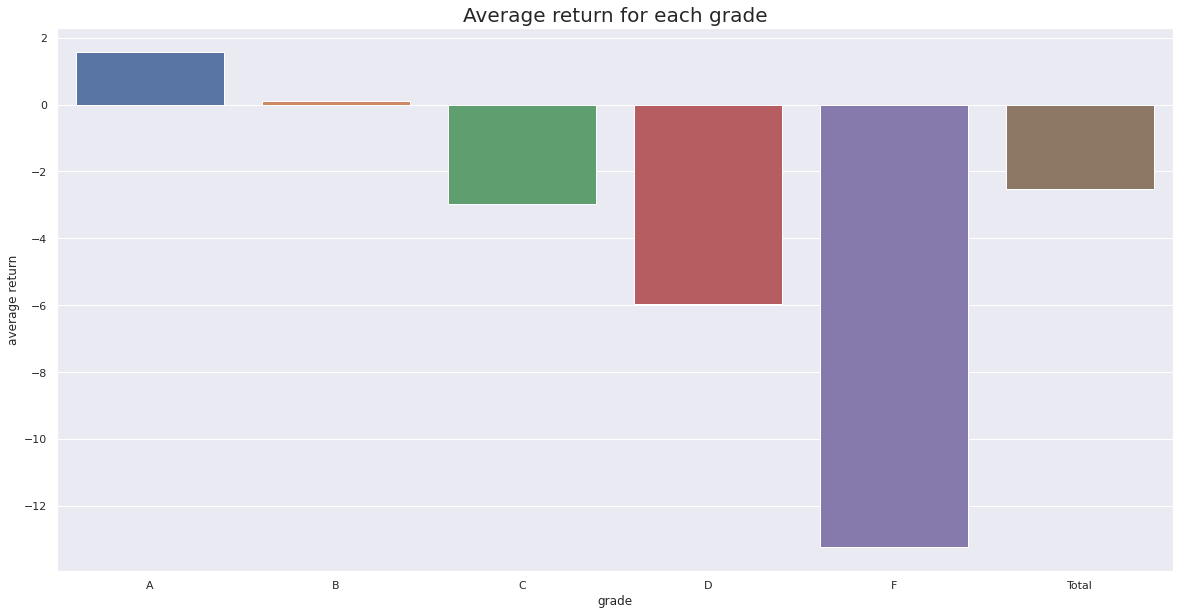

In [ ]:
sns.barplot(sharpe_table.grade,sharpe_table.avg_ret)
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Average return for each grade', fontsize=20)
plt.ylabel('average return')
plt.xlabel('grade', fontsize=12)
plt.show()

In [ ]:
print("From the analysis above, we know that: in general, p2p loan is not as attractive as it seems because of the huge risk associating with charging off, the average return is about "+xxxx and with a standard deviation of xxxx.

Among all grades, grade A perform the best even with the lowest interest rate.)

In [ ]:
def get_sharpe_table(df_hist):
  sharpe_table_dtl = pd.DataFrame(0, index=np.arange(26), columns=["sub_grade","int_rate","avg_ret","std_ret","Sharpe Ratio"])
  base_l = df_hist.columns.get_loc("l_1")
  for i in range(5):
    for j in range(5):
      selector_g = df_hist.iloc[:,i + base_n]
      selector_l = df_hist.iloc[:,j + base_l]
      sharpe_table_dtl.loc[i*5+j,"sub_grade"] = df_hist[selector_g & selector_l].sub_grade.iloc[0]
      sharpe_table_dtl.loc[i*5+j,"avg_ret"] = df_hist[selector_g & selector_l].yr_ret.mean()
      sharpe_table_dtl.loc[i*5+j,"int_rate"] = df_hist[selector_g & selector_l].int_rate.mean()
      sharpe_table_dtl.loc[i*5+j,"std_ret"] = df_hist[selector_g & selector_l].yr_ret.std()
  sharpe_table_dtl.loc[25,"sub_grade"] = "Total"
  sharpe_table_dtl.loc[25,"int_rate"] = df_hist.int_rate.mean()
  sharpe_table_dtl.loc[25,"avg_ret"] = df_hist.yr_ret.mean()
  sharpe_table_dtl.loc[25,"std_ret"] = df_hist.yr_ret.std()
  sharpe_table_dtl["Sharpe Ratio"]=sharpe_table_dtl["avg_ret"]/sharpe_table_dtl["std_ret"]
  return sharpe_table_dtl

In [ ]:
sharpe_table_dtl = get_sharpe_table(df_hist)

In [ ]:
sharpe_table_dtl

,sub_grade,int_rate,avg_ret,std_ret,Sharpe Ratio
0,A1,5.526542,1.982558,11.304823,0.175373
1,A2,6.517445,1.749553,13.756174,0.127183
2,A3,7.106414,1.859735,14.792417,0.125722
3,A4,7.506172,1.114646,16.509852,0.067514
4,A5,8.198980,1.342003,17.991172,0.074592
5,B1,8.894245,0.125308,20.784934,0.006029
6,B2,9.917510,0.741740,20.432359,0.036302
7,B3,10.778007,0.621619,21.479368,0.028940
8,B4,11.507274,0.238646,22.918473,0.010413
9,B5,12.002242,-1.205395,25.555165,-0.047168


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


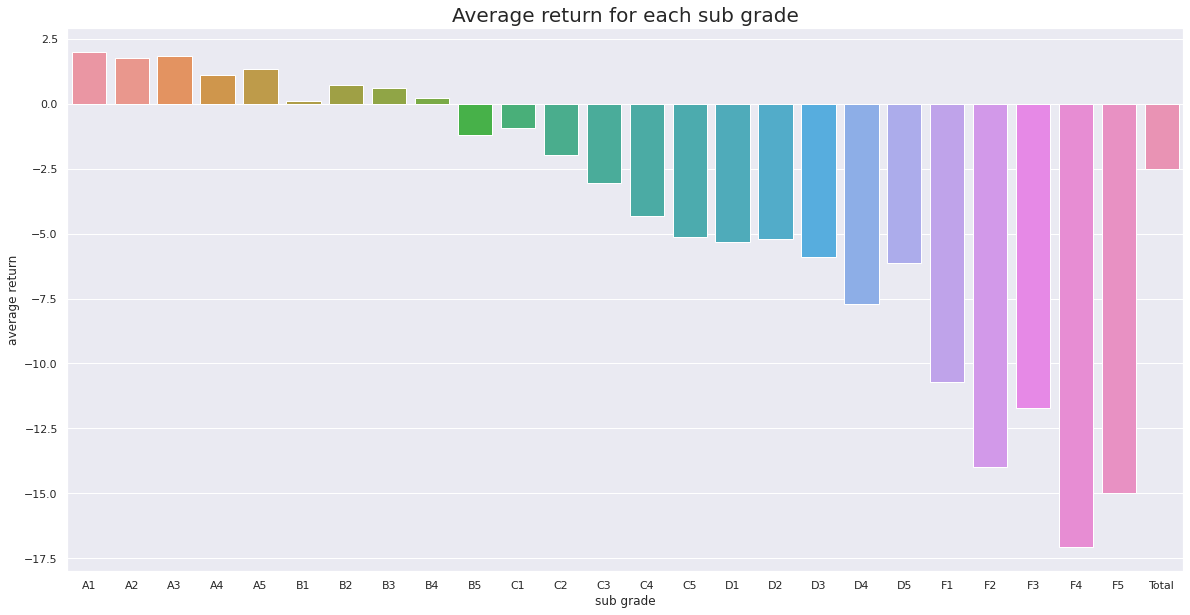

In [ ]:
sns.barplot(sharpe_table_dtl.sub_grade,sharpe_table_dtl.avg_ret)
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Average return for each sub grade', fontsize=20)
plt.ylabel('average return')
plt.xlabel('sub grade', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


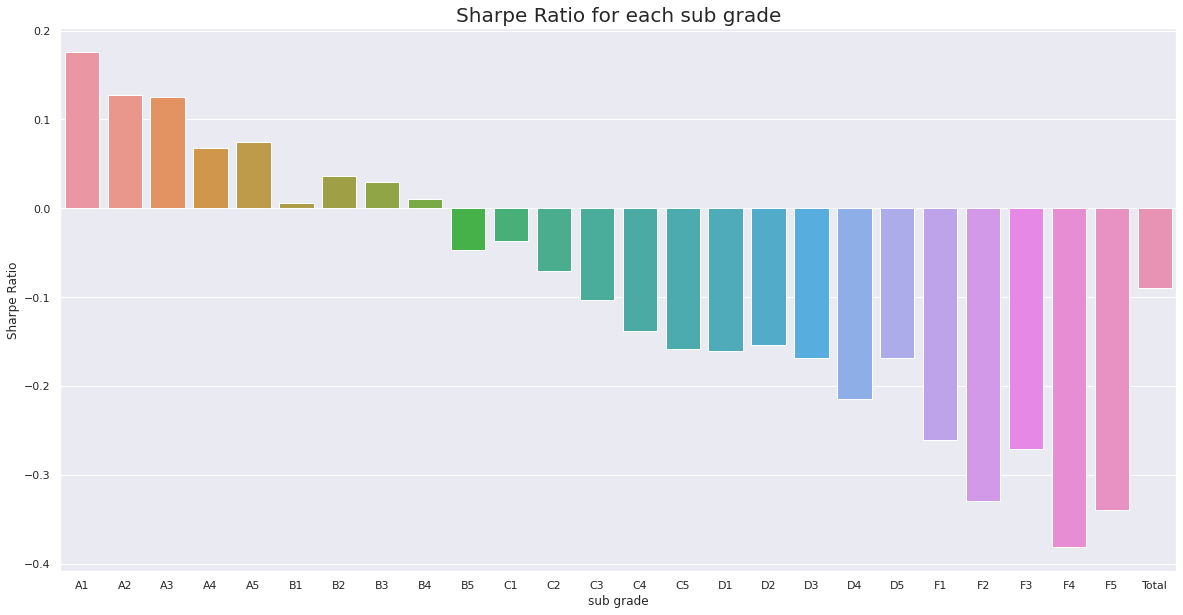

In [ ]:
sns.barplot(sharpe_table_dtl.sub_grade,sharpe_table_dtl["Sharpe Ratio"])
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Sharpe Ratio for each sub grade', fontsize=20)
plt.ylabel('Sharpe Ratio')
plt.xlabel('sub grade', fontsize=12)
plt.show()

In [ ]:
df_hist

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
2,10.527226,C,C3,Fully Paid,Dec-2013,Nov-2015,False,True,False,False,True,False,False,False,False,True,False,False,False,False,8.0,8.0,NaN,8.0,700.0,9848215,23850.0,36,14.98,826.54,54000.0,15.17,665.0,669.0,75.1,29.0,0.00,624.0,620.0,181763.0,0.0,0.0,0.0,20100.0,0.0,0.0,0.0,1.0,3910.0,9.0,0.0,5.0,0.0,89.7,0.0,201332.0,18500.0,21032.0,0,0,1,1,1,0,1,1,0,1
3,-91.013495,C,C3,In Grace Period,Jul-2018,Feb-2019,False,False,False,False,True,False,False,False,False,True,False,False,False,False,12.0,86.0,NaN,12.0,215.0,136521416,34625.0,36,15.02,1200.63,76960.0,36.94,710.0,714.0,19.6,38.0,29051.11,724.0,720.0,248879.0,1.0,1.0,5.0,43300.0,6.0,2.0,1.0,9.0,21833.0,7.0,2.0,11.0,0.0,78.9,0.0,317726.0,27800.0,113560.0,0,0,1,1,1,0,1,1,0,1
4,-99.997599,C,C4,Charged Off,Nov-2016,Feb-2017,False,False,False,False,True,False,False,False,False,False,True,False,False,False,NaN,NaN,86.0,NaN,92.0,93461239,9500.0,36,14.99,329.28,55000.0,12.70,675.0,679.0,11.6,13.0,0.00,569.0,565.0,106246.0,2.0,1.0,2.0,9000.0,8.0,4.0,13.0,6.0,2761.0,3.0,1.0,3.0,0.0,92.3,1.0,114860.0,3500.0,27408.0,0,0,1,1,1,0,1,0,0,1
5,7.061028,B,B1,Fully Paid,Nov-2011,Sep-2013,False,True,False,True,False,False,False,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,670.0,1017115,6800.0,36,9.91,219.13,53000.0,2.99,790.0,794.0,3.4,10.0,0.00,749.0,745.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,1
7,-76.256486,B,B4,Charged Off,Nov-2015,Aug-2016,False,False,False,True,False,False,False,False,False,False,True,False,False,False,NaN,NaN,NaN,NaN,274.0,64069013,25000.0,36,10.99,818.35,85000.0,14.37,660.0,664.0,89.5,17.0,0.00,499.0,0.0,39671.0,0.0,0.0,0.0,33800.0,0.0,0.0,0.0,1.0,3164.0,0.0,0.0,11.0,0.0,100.0,0.0,48800.0,33300.0,15000.0,0,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,20.102453,E,E3,Fully Paid,Jul-2014,Jun-2015,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,NaN,NaN,NaN,335.0,20298617,11800.0,60,20.20,313.95,45000.0,6.29,660.0,664.0,93.0,27.0,0.00,639.0,635.0,106777.0,0.0,0.0,0.0,17000.0,0.0,0.0,0.0,3.0,811.0,1.0,0.0,3.0,0.0,100.0,0.0,95969.0,13000.0,78969.0,0,0,1,1,1,1,0,0,0,1
99995,2.786071,A,A1,Fully Paid,Nov-2015,Oct-2018,False,True,True,False,False,False,False,True,False,False,False,False,False,False,NaN,NaN,NaN,37.0,1065.0,65642231,8000.0,36,5.32,240.92,130000.0,2.41,695.0,699.0,11.6,18.0,0.00,809.0,805.0,8700.0,0.0,0.0,0.0,25900.0,0.0,0.0,0.0,0.0,13229.0,5.0,2.0,3.0,0.0,88.2,0.0,34224.0,16200.0,0.0,0,0,1,0,1,1,0,0,1,0
99996,-59.650892,E,E2,Charged Off,Aug-2017,Jul-2018,False,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,27.0,334.0,115299153,27600.0,36,23.88,1081.09,60000.0,18.38,680.0,684.0,51.8,31.0,0.00,534.0,530.0,85844.0,1.0,1.0,1.0,42200.0,0.0,9.0,2.0,4.0,16942.0,1.0,0.0,4.0,0.0,90.3,0.0,99431.0,29000.0,57231.0,0,0,1,1,1,1,0,0,0,1
99997,5.583160,B,

####1. Model 1: random sub_grade weight model

In [ ]:
random.seed(2)

In [ ]:
# Split the testing and training set with 25% and 75% respectively
df_hist["test"] = np.random.choice([True,False],size=df_hist["test"].shape[0])
df_hist["train"] = np.random.choice([True,False],size=df_hist["train"].shape[0])
df_hist["test"] = df_hist["train"] & df_hist["test"]
df_hist["train"] = ~(df_hist["test"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
  train_sharpe_table = pd.DataFrame(0, index=np.arange(26), columns=["sub_grade","int_rate","avg_ret","std_ret","Sharpe Ratio"])
  base_l = df_hist[df_hist["train"]].columns.get_loc("l_1")
  for i in range(5):
    for j in range(5):
      selector_g = df_hist[df_hist["train"]].iloc[:,i + base_n]
      selector_l = df_hist[df_hist["train"]].iloc[:,j + base_l]
      #print(i,j,df_hist[df_hist["train"]][selector_g & selector_l].shape[0])
      if df_hist[df_hist["train"]][selector_g & selector_l].shape[0]>0:
        train_sharpe_table.loc[i*5+j,"sub_grade"] = df_hist[df_hist["train"]][selector_g & selector_l].sub_grade.iloc[0]
        train_sharpe_table.loc[i*5+j,"avg_ret"] = df_hist[df_hist["train"]][selector_g & selector_l].yr_ret.mean()
        train_sharpe_table.loc[i*5+j,"int_rate"] = df_hist[df_hist["train"]][selector_g & selector_l].int_rate.mean()
        train_sharpe_table.loc[i*5+j,"std_ret"] = df_hist[df_hist["train"]][selector_g & selector_l].yr_ret.std()
  train_sharpe_table.loc[25,"sub_grade"] = "Total"
  train_sharpe_table.loc[25,"int_rate"] = df_hist[df_hist["train"]].int_rate.mean()
  train_sharpe_table.loc[25,"avg_ret"] = df_hist[df_hist["train"]].yr_ret.mean()
  train_sharpe_table.loc[25,"std_ret"] = df_hist[df_hist["train"]].yr_ret.std()
  train_sharpe_table["Sharpe Ratio"]=train_sharpe_table["avg_ret"]/train_sharpe_table["std_ret"]

In [ ]:
train_sharpe_table['weight_g'] = 0

In [ ]:
train_sharpe_table.loc[(train_sharpe_table["Sharpe Ratio"]>0)&~(train_sharpe_table["Sharpe Ratio"].isna()),
                       "weight_g"] = train_sharpe_table["Sharpe Ratio"]
train_sharpe_table.loc[train_sharpe_table["sub_grade"]=="Total","weight_g"] = 0

In [ ]:
train_sharpe_table["weight_g"] = train_sharpe_table["weight_g"]/train_sharpe_table.weight_g.sum()

In [ ]:
train_sharpe_table

,sub_grade,int_rate,avg_ret,std_ret,Sharpe Ratio,weight_g
0,A1,5.528251,2.028544,11.287736,0.179712,0.291387
1,A2,6.520694,1.792916,13.825452,0.129682,0.210268
2,A3,7.106742,1.602013,15.398755,0.104035,0.168684
3,A4,7.496655,1.052209,16.603193,0.063374,0.102755
4,A5,8.193924,1.259846,18.643666,0.067575,0.109567
5,B1,8.897375,0.025007,20.944394,0.001194,0.001936
6,B2,9.924183,1.008943,20.132754,0.050115,0.081256
7,B3,10.783090,0.279468,22.083779,0.012655,0.020519
8,B4,11.515668,0.193751,23.051958,0.008405,0.013628
9,B5,12.013226,-0.912801,24.956448,-0.036576,0.000000


#####1.1 Test with a portfolio

In [ ]:
  test_sharpe_table = pd.DataFrame(0, index=np.arange(26), columns=["sub_grade","int_rate","avg_ret","std_ret","Sharpe Ratio"])
  base_l = df_hist[df_hist["test"]].columns.get_loc("l_1")
  for i in range(5):
    for j in range(5):
      selector_g = df_hist[df_hist["test"]].iloc[:,i + base_n]
      selector_l = df_hist[df_hist["test"]].iloc[:,j + base_l]
      #print(i,j,df_hist[df_hist["test"]][selector_g & selector_l].shape[0])
      if df_hist[df_hist["test"]][selector_g & selector_l].shape[0]>0:
        test_sharpe_table.loc[i*5+j,"sub_grade"] = df_hist[df_hist["test"]][selector_g & selector_l].sub_grade.iloc[0]
        test_sharpe_table.loc[i*5+j,"avg_ret"] = df_hist[df_hist["test"]][selector_g & selector_l].yr_ret.mean()
        test_sharpe_table.loc[i*5+j,"int_rate"] = df_hist[df_hist["test"]][selector_g & selector_l].int_rate.mean()
        test_sharpe_table.loc[i*5+j,"std_ret"] = df_hist[df_hist["test"]][selector_g & selector_l].yr_ret.std()
  test_sharpe_table.loc[25,"sub_grade"] = "Total"
  test_sharpe_table.loc[25,"int_rate"] = df_hist[df_hist["test"]].int_rate.mean()
  test_sharpe_table.loc[25,"avg_ret"] = df_hist[df_hist["test"]].yr_ret.mean()
  test_sharpe_table.loc[25,"std_ret"] = df_hist[df_hist["test"]].yr_ret.std()
  test_sharpe_table["Sharpe Ratio"]=test_sharpe_table["avg_ret"]/test_sharpe_table["std_ret"]

In [ ]:
test_sharpe_table["std_ret"] = test_sharpe_table["std_ret"].fillna(0)
test_sharpe_table["Sharpe Ratio"] = test_sharpe_table["Sharpe Ratio"].fillna(0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


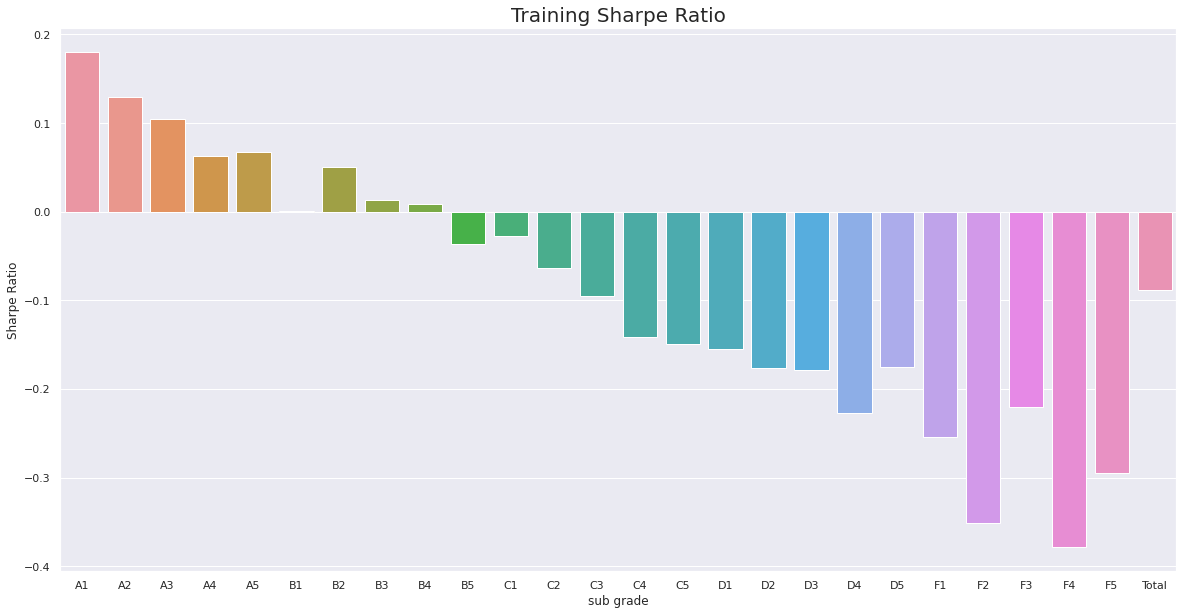

In [ ]:
sns.barplot(train_sharpe_table.sub_grade,train_sharpe_table["Sharpe Ratio"])
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Training Sharpe Ratio', fontsize=20)
plt.ylabel('Sharpe Ratio')
plt.xlabel('sub grade', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


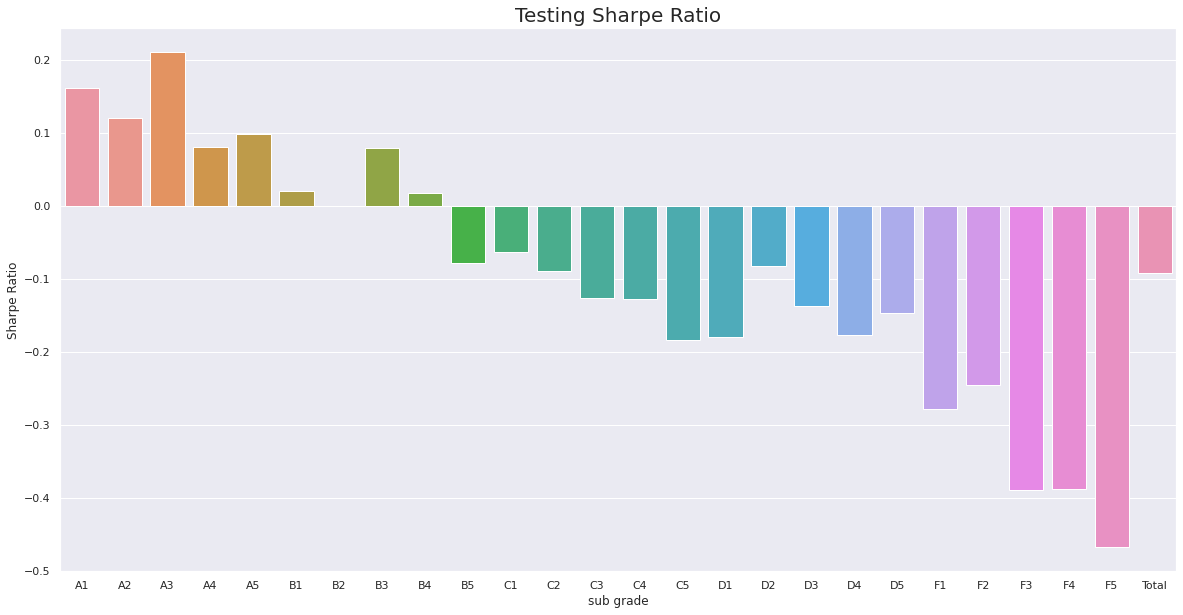

In [ ]:
sns.barplot(test_sharpe_table.sub_grade,test_sharpe_table["Sharpe Ratio"])
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Testing Sharpe Ratio', fontsize=20)
plt.ylabel('Sharpe Ratio')
plt.xlabel('sub grade', fontsize=12)
plt.show()

In [ ]:
test_return = test_sharpe_table['avg_ret'].dot(train_sharpe_table["weight_g"])
test_std = test_sharpe_table['std_ret'].dot(train_sharpe_table["weight_g"])
test_sharpe = test_sharpe_table['Sharpe Ratio'].dot(train_sharpe_table["weight_g"])

#####1.2 Conclusion

In [ ]:
print("The return of the test portfolio is "+str(test_return)+"% with a standard deviation of "+str(test_std) +" and thus a Sharpe ratio of "+
      str(test_sharpe)+". ")

The return of the test portfolio is 1.6674019734612548% with a standard deviation of 14.204738048857088 and thus a Sharpe ratio of 0.1283609539941953. 


####2. Model 2: Subset feature selection Model

In [ ]:
df_hist = df[~(df["Current"])]

In [ ]:
#check for nan
df_hist = df_hist[~df_hist.iloc[:,x_s:].isna().any(axis=1)]
df_hist[df_hist.iloc[:,x_s:].isna().any(axis=1)]

,yr_ret,grade,sub_grade,loan_status,issue_d,last_pymnt_d,Current,Paid,g_A,g_B,g_C,g_D,g_F,l_1,l_2,l_3,l_4,l_5,train,test,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,mths_since_last_record,mths_since_last_delinq,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,actual_repayment_difference,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f


In [ ]:
# Split the testing and training set with 25% and 75% respectively
df_hist["test"] = np.random.choice([True,False],size=df_hist["test"].shape[0])
df_hist["train"] = np.random.choice([True,False],size=df_hist["train"].shape[0])
df_hist["test"] = df_hist["train"] & df_hist["test"]
df_hist["train"] = ~(df_hist["test"])

In [ ]:
beta_table = pd.DataFrame(0, index=np.arange(26), columns=df_hist.iloc[:,x_s:].columns)
beta_table
base_n = df_hist.columns.get_loc("g_A")
base_l = df_hist[df_hist["train"]].columns.get_loc("l_1")
for i in range(5):
  for j in range(5):
    selector_g = df_hist[df_hist["train"]].iloc[:,i + base_n]
    selector_l = df_hist[df_hist["train"]].iloc[:,j + base_l]
    X = df_hist[df_hist["train"]][selector_g & selector_l].iloc[:,x_s:]
    y = df_hist[df_hist["train"]][selector_g & selector_l].iloc[:,0]
    if X.shape[0]>0:
      # Create linear regression object
      regr = linear_model.LinearRegression()
      # Train the model using the training sets
      regr.fit(X, y)
      beta_table.loc[i*5+j,:] = regr.coef_.transpose()
beta_table.head()

,actual_repayment_time,id,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,revol_util,total_acc,out_prncp,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_rv_12m,open_rv_24m,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,actual_repayment_difference,pur_car,pur_creditCard,pur_debt,red_flag,Credit_Urgency_75%,home_rent,home_mortgage,emp_length_over_10,initial_list_status_w,initial_list_status_f
0,-3.066633e+11,0.043125,-96.742324,2.619865e+11,-1.615187,92.354621,0.701446,-0.330185,-18.159304,17.665859,1.002562,-0.517129,-18.446022,4.463525,0.219488,2.135446,-0.551230,0.283587,0.523007,-0.156653,-0.712115,0.040222,0.070833,-0.115666,0.861110,-0.047615,0.625827,-0.225534,0.269747,0.517277,0.406513,-2.466585,-0.312108,0.389032,-8.082545e+08,3.296571,0.014234,0.396401,1.359856,-2.360851,0.951611,1.370003,1.047307,-0.303846,0.306966
1,-6.725171e+09,-1.132322,-12.321481,5.745402e+09,10.467835,11.575598,0.243084,-0.833184,-0.951247,-0.951226,-0.545968,-0.060633,-20.480300,5.415397,0.778866,-2.456630,-0.847898,0.474477,-1.236513,-0.413512,1.771992,0.481328,-0.018723,-0.069867,1.155950,-0.184320,-0.994363,1.318793,-0.062017,0.443909,-0.620909,3.456999,-1.743249,0.501146,-1.772514e+07,2.668075,-0.314505,-0.049855,0.617990,-3.915265,-2.256008,-2.032044,0.771671,0.564873,-0.564875
2,-9.986247e+11,1.878082,-29.496441,8.531382e+11,7.846189,26.573622,0.450594,-0.090116,-88.250609,87.310623,0.258665,0.077259,-20.262696,0.900571,6.488945,-0.471412,0.458470,-2.152532,0.149940,-0.302578,0.125930,-0.087874,-0.618981,0.685428,-0.267128,0.152021,0.225952,-0.582550,0.074893,-0.094019,-0.365948,0.905077,0.936696,0.225554,-2.632016e+09,2.221691,0.398991,1.012130,0.341211,-1.206142,0.566328,1.297257,-0.890456,-0.300095,0.299896
3,2.898472e+00,0.253058,-16.126422,3.392760e+00,12.490087,14.077902,0.749795,0.303417,-0.543083,-0.543072,-0.541678,-0.465261,-19.957038,6.970722,1.169592,3.640711,1.443689,-1.246823,-1.210868,1.743610,0.448534,-0.078037,-0.441911,0.951669,-0.304300,0.279224,-0.660991,-0.592403,0.156173,-0.031693,0.571744,-3.603896,-1.081124,0.590536,2.694949e-03,-4.233095,2.002950,1.739304,-1.635354,-0.758502,0.696254,1.351397,1.224181,0.658703,-0.658703
4,1.041903e+00,-0.780072,-8.341734,1.219573e+00,4.213164,7.674593,-0.140499,-0.491706,-0.386110,-0.386102,-0.148064,0.246820,-20.640396,6.564110,0.916304,-1.544332,-1.537217,0.587691,0.244780,0.427737,0.258607,0.845825,-0.521540,0.744911,0.089906,0.149497,-0.003347,-0.939773,-0.047409,-0.469777,0.754256,2.244409,-0.570531,-0.054431,-2.130758e-03,15.333882,-0.074687,0.035558,-0.628557,2.223259,1.017963,1.115548,-0.722152,0.695644,-0.695644


#####2.1 Test the model

In [ ]:
top_n = 5
return_table = pd.DataFrame(0, index=np.arange(top_n), columns=sharpe_table_dtl["sub_grade"])
return_table.drop(columns=['Total'], inplace=True)

In [ ]:
base_n = df_hist.columns.get_loc("g_A")
base_l = df_hist[df_hist["test"]].columns.get_loc("l_1")
for i in range(5):
  for j in range(5):
    selector_g = df_hist[df_hist["test"]].iloc[:,i + base_n]
    selector_l = df_hist[df_hist["test"]].iloc[:,j + base_l]
    X = df_hist[df_hist["test"]][selector_g & selector_l].iloc[:,x_s:]
    y = df_hist[df_hist["test"]][selector_g & selector_l].iloc[:,0]
    len_test = X.shape[0]
    beta = beta_table.iloc[i*5+j,:]
    ret_array = []
    actual_array = []
    if len_test > top_n:
      for x in range(len_test):
        ret = beta.dot(X.iloc[x,:])
        ret_array.append(ret)
        actual_array.append(y.iloc[x])
      predict_actual = pd.DataFrame({'predict': ret_array, 'actual': actual_array}, columns=['predict', 'actual'])
      sorted = predict_actual.sort_values(by=['predict'],ascending=False)
      return_table.loc[:,return_table.columns[i*5+j]] = sorted.iloc[:,1]

In [ ]:
return_table

sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,F1,F2,F3,F4,F5
0,5.510602,4.994625,6.847047,7.068428,6.480343,5.383575,11.393694,5.321291,-76.256486,6.735698,8.109185,10.145752,10.527226,9.976246,-29.034456,9.898366,11.386155,16.146834,8.727551,19.380303,-99.627596,22.600262,19.865683,-94.445886,20.897479
1,4.262242,3.357712,6.625459,5.860090,-33.950445,8.274444,8.389872,-5.545105,9.748532,7.194338,-14.950732,-88.308755,-44.416499,9.657109,11.421300,11.044151,-6.356996,8.661999,16.822607,10.806538,18.671402,-82.400723,12.810448,-52.158182,22.243422
2,5.289376,3.282515,6.091274,7.050341,4.577246,10.428599,6.509152,7.428631,8.087744,8.531251,-93.486900,14.043302,-17.751233,9.214502,-19.525880,8.302634,16.596136,8.900410,9.710513,3.432218,-68.949420,0.487578,15.566079,-98.348309,25.809076
3,4.497852,3.221739,6.234818,6.120059,6.770110,8.151983,8.941496,5.023794,-74.794118,-24.280429,-9.578290,-38.876723,-78.924614,-4.533972,-39.279433,19.050186,-62.879331,11.051477,17.973691,9.573499,-8.865093,-52.231533,-39.896241,4.213932,18.366412
4,4.305605,3.829331,4.664211,-52.834200,3.964778,-3.567529,-33.836543,5.093704,13.343623,9.627739,-47.574178,9.710259,7.473063,16.614392,11.443962,-36.673432,10.800681,13.637727,12.243730,9.073666,-24.451550,26.419864,-99.081548,-98.784068,-70.505249


#####2.2 Combine with Model One

In [ ]:
return_table = return_table.transpose()

In [ ]:
return_table["weight_g"] = train_sharpe_table["weight_g"][1:,].to_numpy()

In [ ]:
return_table["sub_grade"] = sharpe_table_dtl["sub_grade"][1:,].to_numpy()

In [ ]:
return_table["avg_ret"] = return_table.iloc[:, 0:top_n-1].mean(axis=1)

In [ ]:
return_table["sum_ret"] = return_table["avg_ret"]*return_table["weight_g"]

In [ ]:
return_table

,0,1,2,3,4,weight_g,sub_grade,avg_ret,sum_ret
sub_grade,,,,,,,,,
A1,5.510602,4.262242,5.289376,4.497852,4.305605,0.210268,A2,4.890018,1.028215
A2,4.994625,3.357712,3.282515,3.221739,3.829331,0.168684,A3,3.714148,0.626516
A3,6.847047,6.625459,6.091274,6.234818,4.664211,0.102755,A4,6.449650,0.662734
A4,7.068428,5.860090,7.050341,6.120059,-52.834200,0.109567,A5,6.524730,0.714894
A5,6.480343,-33.950445,4.577246,6.770110,3.964778,0.001936,B1,-4.030687,-0.007803
B1,5.383575,8.274444,10.428599,8.151983,-3.567529,0.081256,B2,8.059650,0.654897
B2,11.393694,8.389872,6.509152,8.941496,-33.836543,0.020519,B3,8.808553,0.180741
B3,5.321291,-5.545105,7.428631,5.023794,5.093704,0.013628,B4,3.057153,0.041663
B4,-76.256486,9.748532,8.087744,-74.794118,13.343623,0.000000,B5,-33.303582,-0.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


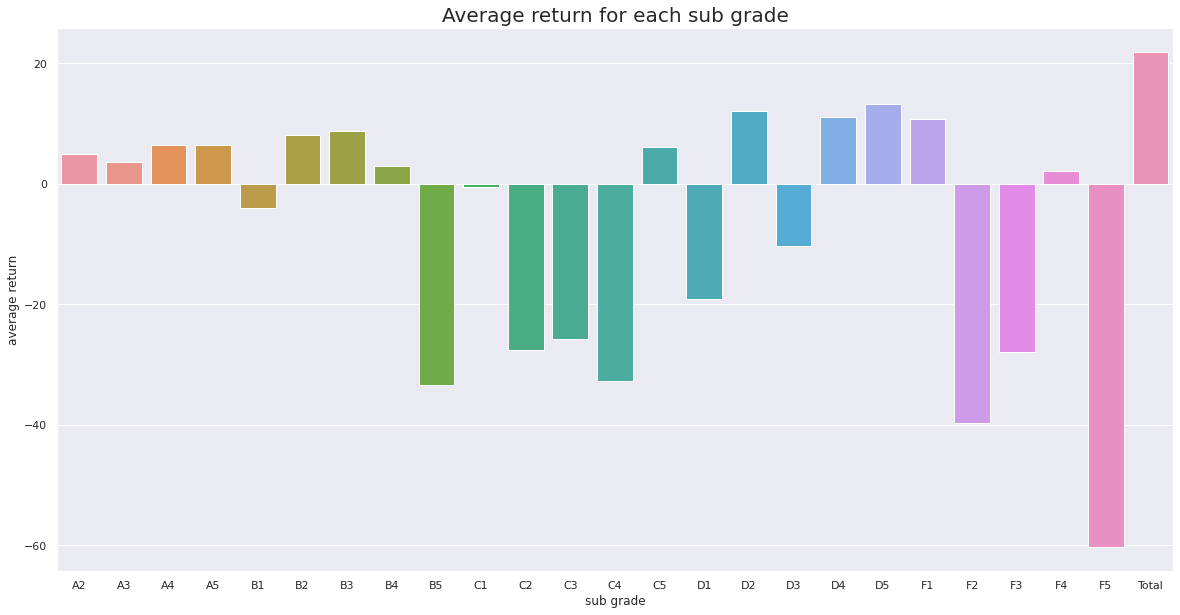

In [ ]:
sns.barplot(return_table.sub_grade,return_table.avg_ret)
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Average return for each sub grade', fontsize=20)
plt.ylabel('average return')
plt.xlabel('sub grade', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


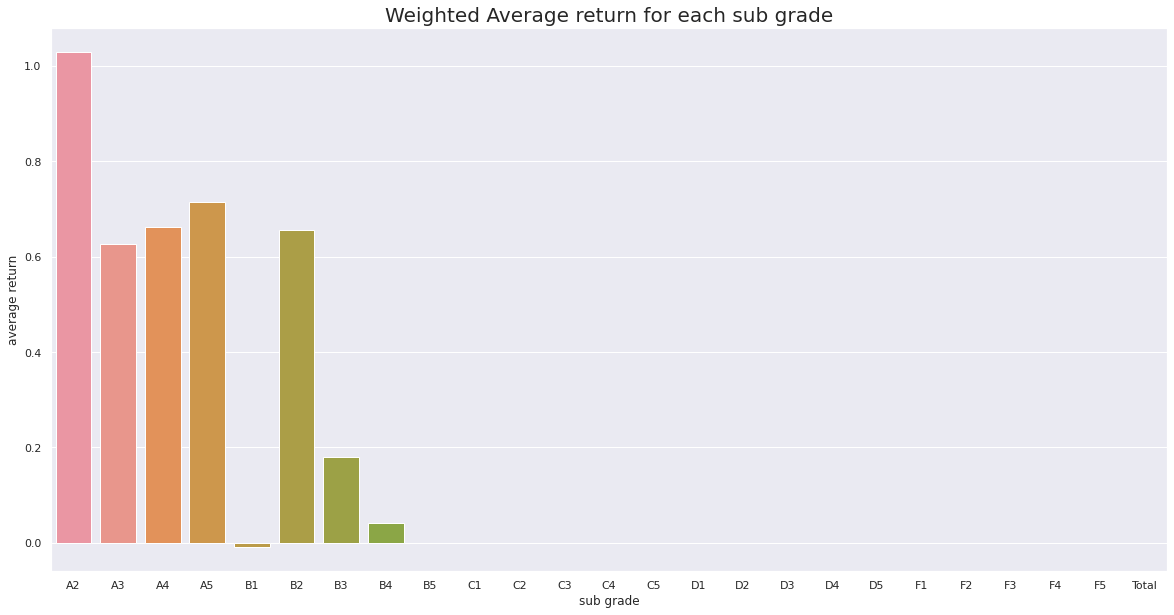

In [ ]:
sns.barplot(return_table.sub_grade,return_table.sum_ret)
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Weighted Average return for each sub grade', fontsize=20)
plt.ylabel('average return')
plt.xlabel('sub grade', fontsize=12)
plt.show()

#####2.3 Conclusion

In [ ]:
print("The return of the test portfolio is "+str(return_table.sum_ret.sum())+"%. ")

The return of the test portfolio is 3.9018570834931605%. 


# PART III Portfolio Simulation

In [ ]:
simulation_table = pd.DataFrame(0, index=np.arange(20), columns=["5","10","15","20"])
for s in range(20):
  for t in [5,10,15,20]:
    random.seed(s)
    # Split the testing and training set with 25% and 75% respectively
    df_hist["test"] = np.random.choice([True,False],size=df_hist["test"].shape[0])
    df_hist["train"] = np.random.choice([True,False],size=df_hist["train"].shape[0])
    df_hist["test"] = df_hist["train"] & df_hist["test"]
    df_hist["train"] = ~(df_hist["test"])
    beta_table = pd.DataFrame(0, index=np.arange(26), columns=df_hist.iloc[:,x_s:].columns)
    base_n = df_hist.columns.get_loc("g_A")
    base_l = df_hist[df_hist["train"]].columns.get_loc("l_1")
    for i in range(5):
      for j in range(5):
        selector_g = df_hist[df_hist["train"]].iloc[:,i + base_n]
        selector_l = df_hist[df_hist["train"]].iloc[:,j + base_l]
        X = df_hist[df_hist["train"]][selector_g & selector_l].iloc[:,x_s:]
        y = df_hist[df_hist["train"]][selector_g & selector_l].iloc[:,0]
        if X.shape[0]>0:
          # Create linear regression object
          regr = linear_model.LinearRegression()
          # Train the model using the training sets
          regr.fit(X, y)
          beta_table.loc[i*5+j,:] = regr.coef_.transpose()
    top_n = t
    return_table = pd.DataFrame(0, index=np.arange(top_n), columns=sharpe_table_dtl["sub_grade"])
    return_table.drop(columns=['Total'], inplace=True)
    base_n = df_hist.columns.get_loc("g_A")
    base_l = df_hist[df_hist["test"]].columns.get_loc("l_1")
    for i in range(5):
      for j in range(5):
        selector_g = df_hist[df_hist["test"]].iloc[:,i + base_n]
        selector_l = df_hist[df_hist["test"]].iloc[:,j + base_l]
        X = df_hist[df_hist["test"]][selector_g & selector_l].iloc[:,x_s:]
        y = df_hist[df_hist["test"]][selector_g & selector_l].iloc[:,0]
        len_test = X.shape[0]
        beta = beta_table.iloc[i*5+j,:]
        ret_array = []
        actual_array = []
        if len_test > top_n:
          for x in range(len_test):
            ret = beta.dot(X.iloc[x,:])
            ret_array.append(ret)
            actual_array.append(y.iloc[x])
          predict_actual = pd.DataFrame({'predict': ret_array, 'actual': actual_array}, columns=['predict', 'actual'])
          sorted = predict_actual.sort_values(by=['predict'],ascending=False)
          return_table.loc[:,return_table.columns[i*5+j]] = sorted.iloc[:,1]
    return_table
    return_table = return_table.transpose()
    return_table["weight_g"] = train_sharpe_table["weight_g"][1:,].to_numpy()
    return_table["sub_grade"] = sharpe_table_dtl["sub_grade"][1:,].to_numpy()
    return_table["avg_ret"] = return_table.iloc[:, 0:top_n-1].mean(axis=1)
    return_table["sum_ret"] = return_table["avg_ret"]*return_table["weight_g"]
    return_final = return_table.sum_ret.sum()
    simulation_table.loc[s,t] = return_final

**굵은 텍스트**# 새 섹션

In [ ]:
simulation_table

,5,10,15,20,5,10,15,20
0,0,0,0,0,2.830537,2.880839,2.236273,2.317488
1,0,0,0,0,2.531061,1.178089,2.713586,3.100514
2,0,0,0,0,3.345009,0.862714,1.620767,0.056923
3,0,0,0,0,2.886492,2.172740,2.004961,1.539203
4,0,0,0,0,-2.085014,1.949867,0.954511,2.601735
5,0,0,0,0,2.937016,1.194222,2.007496,1.500555
6,0,0,0,0,2.560193,2.326837,2.577074,1.377493
7,0,0,0,0,2.717325,2.099292,2.329162,-0.661195
8,0,0,0,0,2.482812,2.514857,1.238631,-0.006446
9,0,0,0,0,3.558745,1.590405,0.991068,0.533555


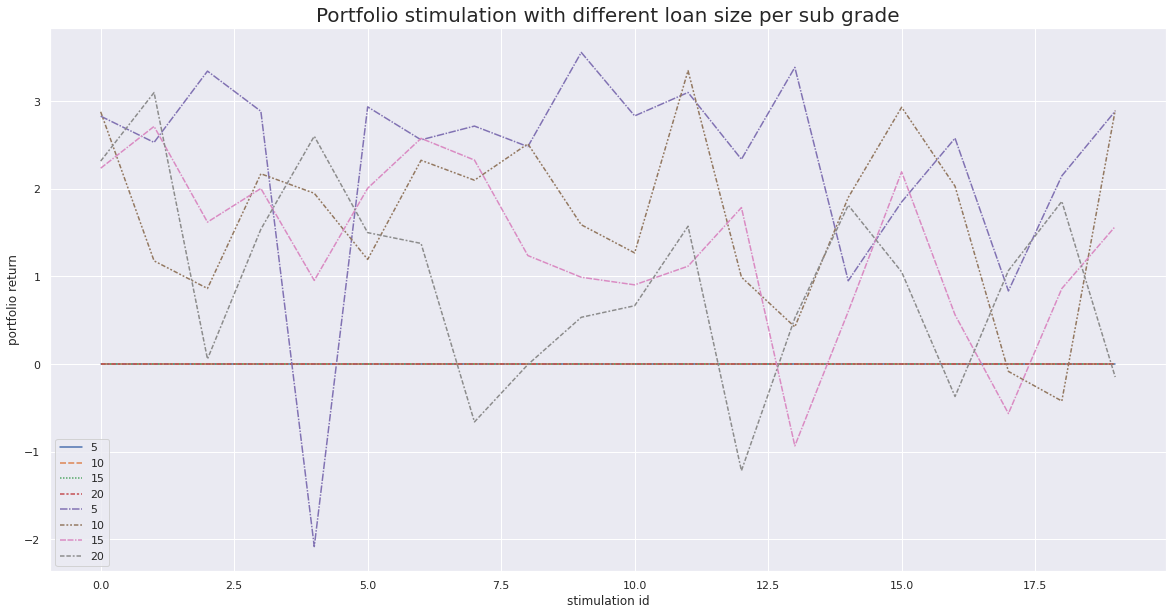

In [ ]:
sns.lineplot(data=simulation_table)
sns.set(rc={'figure.figsize':(20,10)})
plt.title('Portfolio stimulation with different loan size per sub grade', fontsize=20)
plt.ylabel('portfolio return')
plt.xlabel('stimulation id', fontsize=12)
plt.show()

In [ ]:
avg_return = []
simulation_table

,5,10,15,20,5,10,15,20
0,0,0,0,0,2.830537,2.880839,2.236273,2.317488
1,0,0,0,0,2.531061,1.178089,2.713586,3.100514
2,0,0,0,0,3.345009,0.862714,1.620767,0.056923
3,0,0,0,0,2.886492,2.172740,2.004961,1.539203
4,0,0,0,0,-2.085014,1.949867,0.954511,2.601735
5,0,0,0,0,2.937016,1.194222,2.007496,1.500555
6,0,0,0,0,2.560193,2.326837,2.577074,1.377493
7,0,0,0,0,2.717325,2.099292,2.329162,-0.661195
8,0,0,0,0,2.482812,2.514857,1.238631,-0.006446
9,0,0,0,0,3.558745,1.590405,0.991068,0.533555


In [ ]:
print("Our model will give a return of " +str(simulation_table.iloc[:,0].mean())+"%. which is significantly better than a randomly selected p2p loan portfolio of "+str(test_sharpe_table.avg_ret.iloc[-1])+"%. ")

Our model will give a return of 0.0%. which is significantly better than a randomly selected p2p loan portfolio of -2.579873365771563%. 


# PART IV Portfolio Recommendation

In [ ]:
print("We are recommending a sector weight of ")

We are recommending a sector weight of 


In [ ]:
train_sharpe_table[["sub_grade","weight_g"]]
train_sharpe_table["investment"] = train_sharpe_table["weight_g"]*10000000
train_sharpe_table[["sub_grade","weight_g","investment"]]

,sub_grade,weight_g,investment
0,A1,0.291387,2.913872e+06
1,A2,0.210268,2.102682e+06
2,A3,0.168684,1.686838e+06
3,A4,0.102755,1.027551e+06
4,A5,0.109567,1.095669e+06
5,B1,0.001936,1.935927e+04
6,B2,0.081256,8.125622e+05
7,B3,0.020519,2.051877e+05
8,B4,0.013628,1.362793e+05
9,B5,0.000000,0.000000e+00


In [ ]:
print("Within each sub category, we are recommending investing only 5 of the highest predicted return loans according to our stimulation test")

Within each sub category, we are recommending investing only 5 of the highest predicted return loans according to our stimulation test
